#### ***Importing the libraries***

In [1]:
import pandas as pd
import numpy as np 
import pymongo
import seaborn as sns
import matplotlib.pyplot as plt
import random

#### ***Connection to MongoDB***

In [2]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["yelp"]

#### ***Queries***

##### ***Query 1***
How many businesses and reviews are there for each category?

In [ ]:
#By working directly on the "businesses_merged" collection
b_and_r_per_category = db["businesses_merged"].aggregate([{
                                                              "$project" : {
                                                                  "categories" : 1,
                                                                  "reviews" : 1,
                                                                  "business_id" : 1
                                                              }
                                                          },
                                                          {
                                                              "$unwind" : "$categories"
                                                          },
                                                          {
                                                              "$unwind" : "$reviews"
                                                          },
                                                          {
                                                              "$group" : {
                                                                  "_id" : "$categories",
                                                                  "num_reviews" : {
                                                                      "$sum" : 1
                                                                  },
                                                                  "ids" : {
                                                                      #"$addToSet" is used to push "business_id" in the set called "ids"
                                                                      "$addToSet" : "$business_id"
                                                                  }
                                                              }
                                                          },
                                                          {
                                                              "$project" : {
                                                                  "_id" : 0,
                                                                  "category" : "$_id",
                                                                  "num_businesses" : {
                                                                    "$size" : "$ids"
                                                                  },
                                                                  "num_reviews" : 1
                                                              }
                                                          },
                                                          {
                                                              "$sort" : {
                                                                  "num_businesses" : -1,
                                                                  "num_reviews" : -1
                                                              }
                                                          }])
 
query_df = pd.DataFrame(b_and_r_per_category)
query_df

,num_reviews,category,num_businesses
0,4724464,Restaurants,52268
1,1813588,Food,27781
2,523251,Shopping,24395
3,238255,Home Services,14356
4,370120,Beauty & Spas,14292
...,...,...,...
1306,5,DUI Schools,1
1307,5,Faith-based Crisis Pregnancy Centers,1
1308,5,Fencing Clubs,1
1309,5,Town Hall,1


In [ ]:
#By working separetely on "businesses" and "reviewes" collections and then putting results togheter with Pandas
businesses_per_category = db["businesses"].aggregate([{
                                                          "$unwind" : "$categories"
                                                      },
                                                      {
                                                          "$group" : {
                                                              "_id" : "$categories",
                                                              "num_businesses" : {
                                                                  "$sum" : 1
                                                              }
                                                          }
                                                      },
                                                      {
                                                          "$project" : {
                                                              "_id" : 0,
                                                              "category" : "$_id",
                                                              "num_businesses" : 1
                                                          }
                                                      }])

business_df = pd.DataFrame(businesses_per_category)

reviews_per_category = db["reviews"].aggregate([{
                                                    #In $lookup stage, we are performing a sort of join between "reviews" and "businesses" collections
                                                    "$lookup" : { 
                                                        "from" : "businesses", #"from" specifies the collection to join with "reviews"

                                                        #With "let" we are defining a new variable to use in the following steps
                                                        "let" : { 
                                                            "id" : "$business_id" #"business_id" from "reviews" collection becomes a variable named
                                                        },

                                                        #"pipeline" defines criteria to filter the joined documents
                                                        "pipeline" : [{
                                                                            "$match" : { 
                                                                                #In match we cannot write "x : y" with both x and y document's fields, so we need an equal ($eq) expression ($expr)
                                                                                "$expr" : { 
                                                                                    "$eq" : ["$business_id", "$$id"] #Actual join operation, check that "business_id" (b_id) in "reviews" is the same as "business_id" in "businesses" collections
                                                                                }                                                    
                                                                            }   
                                                                        }],

                                                        #Specifies the field in the output document where the matching documents from "businesses" will be added; it will be an array.
                                                        "as" : "business" 
                                                    }
                                                 },
                                                 {
                                                     "$unwind" : "$business"
                                                 },
                                                 {
                                                     "$unwind" : "$business.categories"
                                                 },
                                                 {
                                                     "$group" : {
                                                         "_id" : "$business.categories",
                                                         "num_reviews" : {
                                                             "$sum" : 1
                                                         }
                                                     }
                                                 },
                                                 {
                                                     "$project" : {
                                                         "_id" : 0,
                                                         "category" : "$_id",
                                                         "num_reviews" : 1
                                                     }
                                                 }])
 
reviews_df = pd.DataFrame(reviews_per_category)

df = pd.merge(business_df, reviews_df, on = "category", how = "inner")
df = df[["category", "num_businesses", "num_reviews"]]
df = df.sort_values(by = ["num_businesses", "num_reviews"], ascending = False)
df

In [ ]:
#By looking up on "businesses" from "reviews" and adding to a set the business_id for each category
b_and_r_per_category = db["reviews"].aggregate([{
                                                    "$lookup" : { 
                                                        "from" : "businesses",
                                                        "let" : { 
                                                            "id" : "$business_id"
                                                        },
                                                        "pipeline" : [{
                                                                            "$match" : { 
                                                                            "$expr" : { 
                                                                                "$eq" : ["$business_id", "$$id"]
                                                                            }                                                    
                                                                            }   
                                                                        }],
                                                        "as" : "business" 
                                                    }
                                                 },
                                                 {
                                                     "$unwind" : "$business"
                                                 },
                                                 {
                                                     "$unwind" : "$business.categories"
                                                 },
                                                 {
                                                     "$group" : {
                                                         "_id" : "$business.categories",
                                                         "num_reviews" : {
                                                             "$sum" : 1
                                                         },
                                                         "ids" : {
                                                             "$addToSet" : "$business.business_id"
                                                         }
                                                     }
                                                 },
                                                 {
                                                     "$project" : {
                                                         "_id" : 0,
                                                         "category" : "$_id",
                                                         "num_businesses" : {
                                                             "$size" : "$ids"
                                                         },
                                                         "num_reviews" : 1
                                                     }
                                                 },
                                                 {
                                                     "$sort" : {
                                                         "num_businesses" : -1,
                                                         "num_reviews" : -1
                                                     }
                                                 }])
 
df = pd.DataFrame(b_and_r_per_category)
df

##### ***Query 2***

A polarizing business is a one with high variance in star ratings. For each category, find the most polarizing businesses.

In [10]:
query_results = db["businesses_merged"].aggregate([{
                                                       "$project" : {
                                                           "business_id" : 1,
                                                           "categories" : 1,
                                                           "reviews.stars" : 1,
                                                           "name" : 1
                                                       }
                                                   },
                                                   {
                                                       "$unwind" : "$categories"
                                                   },
                                                   {
                                                       "$unwind" : "$reviews"
                                                   },                                      
                                                   { 
                                                       "$group" : {
                                                           "_id" : {
                                                               "r_id" : "$business_id",
                                                               "category" : "$categories"
                                                           },
                                                           "name" : {
                                                               #"first" operator is used to keep the first element retreived in grouping stage
                                                               "$first" : "$name"
                                                           },
                                                           "avg_stars" : {
                                                               "$avg": "$reviews.stars"
                                                           },
                                                           "variance" : {
                                                               #"stdDevPop" operator is used to compute the variance
                                                               "$stdDevPop": "$reviews.stars" 
                                                           },
                                                           "num_reviews" : {
                                                               "$sum" : 1
                                                           } 
                                                       }
                                                   },
                                                   {
                                                        "$match" : {
                                                            "num_reviews" : {
                                                                "$gte" : 50
                                                            }
                                                        }  
                                                   },
                                                   {
                                                        "$sort" : {
                                                            "category" : 1,
                                                            "variance" : -1
                                                        }
                                                    },
                                                    {
                                                        "$group" : {
                                                            "_id" : "$_id.category",
                                                            "name" : {
                                                                "$first" : "$name"
                                                            },
                                                            "variance" : {
                                                                "$first" : "$variance"
                                                            },
                                                            "avg_stars" : {
                                                                "$first": "$avg_stars"
                                                            },
                                                            "num_reviews" : {
                                                                "$first": "$num_reviews"
                                                            }
                                                        }
                                                    },
                                                    {
                                                        "$project" : {
                                                            "_id" : 0,
                                                            "category" : "$_id",
                                                            "name" : 1,
                                                            "avg_stars" : 1,
                                                            "num_reviews" : 1,
                                                            "variance" : 1,
                                                        }
                                                    },
                                                    {
                                                        "$sort" : {
                                                            "variance" : -1
                                                        }
                                                    }])
 
#Store the result in a DataFrame
df = pd.DataFrame(query_results)
df

,name,variance,avg_stars,num_reviews,category
0,TyVy Pet Hotel,1.978987,3.183333,60,Veterinarians
1,TyVy Pet Hotel,1.978987,3.183333,60,Pet Groomers
2,TyVy Pet Hotel,1.978987,3.183333,60,Pet Boarding
3,TyVy Pet Hotel,1.978987,3.183333,60,Pet Services
4,TyVy Pet Hotel,1.978987,3.183333,60,Pets
...,...,...,...,...,...
1036,Tremendez Jewelry and Repair,0.133609,4.981818,55,Engraving
1037,Gators Parasail,0.000000,5.000000,66,Sport Equipment Hire
1038,Music City Cats,0.000000,5.000000,54,House Sitters
1039,Marc Bosserman Pianist & Vocalist,0.000000,5.000000,55,Music Production Services


In [26]:
df.to_clipboard()

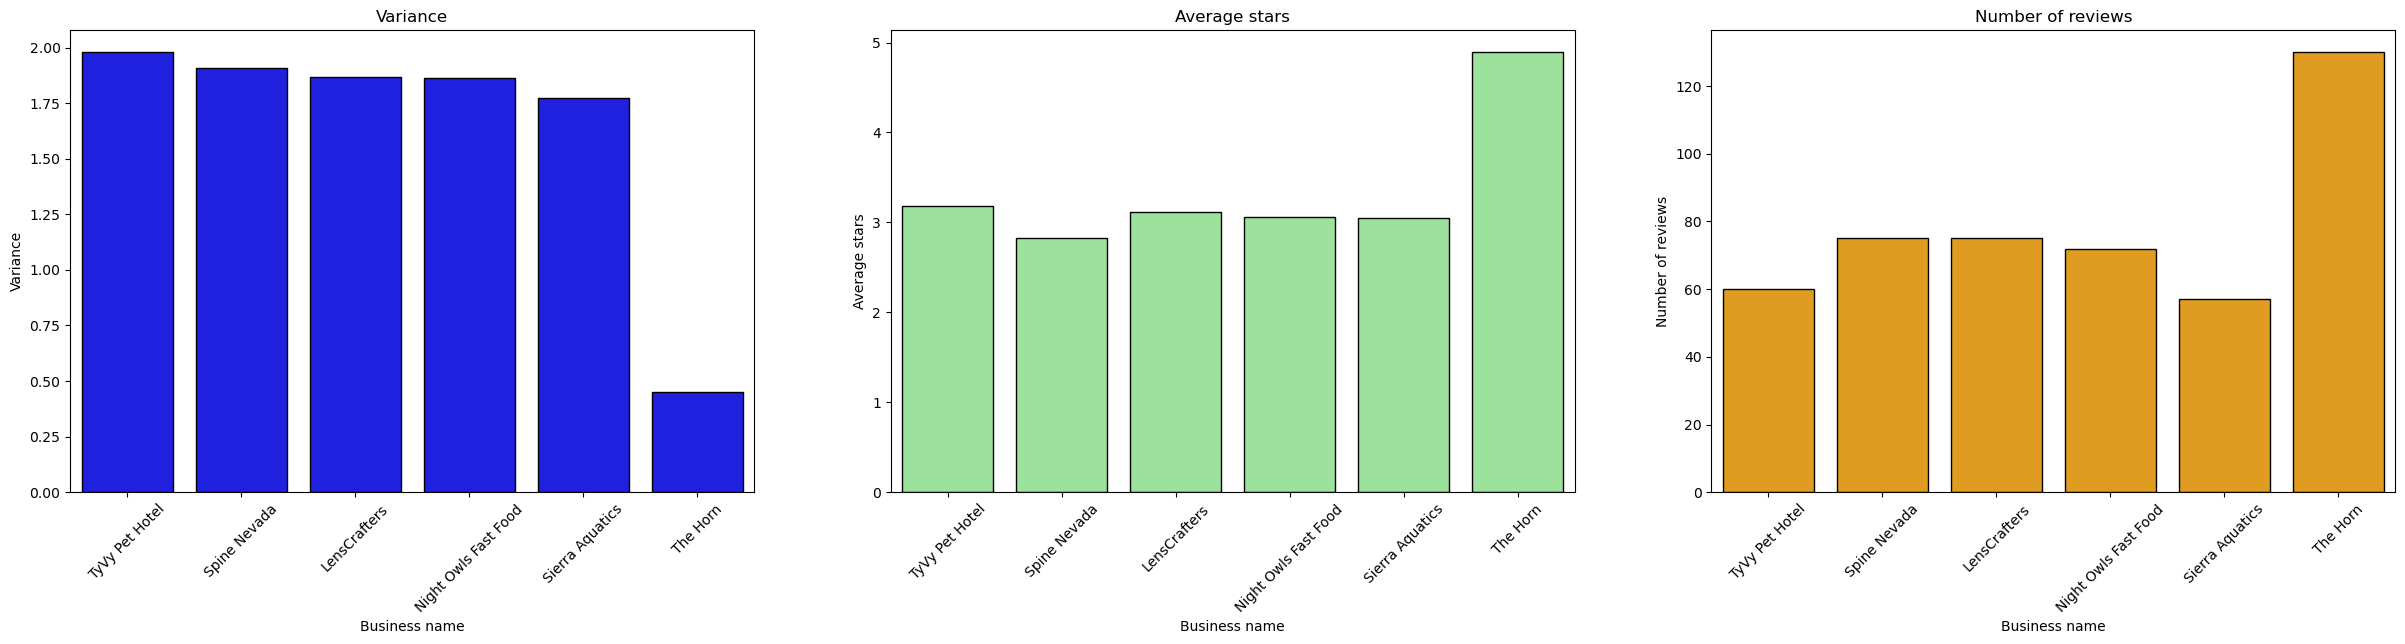

In [25]:
#With this list, we are specifying what categories include in the histogram
categories_of_interest = ["Medical Centers", "Restaurants", "Pets", "Optometrists", "Aquarium Services", "Somali"]

# Filter the DataFrame for the specified categories
filtered_df = df[df["category"].isin(categories_of_interest)]

# Plot histograms for variance, avg_stars, and num_reviews
fig, axes = plt.subplots(1, 3, figsize = (30, 6))

#Variance
sns.barplot(filtered_df, x = "name", y = "variance", ax = axes[0], color = "blue", edgecolor = "black")
axes[0].set_title("Variance")
axes[0].set_xlabel("Business name")
axes[0].set_ylabel("Variance")
axes[0].tick_params(axis = "x", rotation = 45)

#Average stars
sns.barplot(filtered_df, x = "name", y = "avg_stars", ax = axes[1], color = "lightGreen", edgecolor = "black")
axes[1].set_title("Average stars")
axes[1].set_xlabel("Business name")
axes[1].set_ylabel("Average stars")
axes[1].tick_params(axis = "x", rotation = 45)

#Number of reviews
sns.barplot(filtered_df, x = "name", y = "num_reviews", ax = axes[2], color = "orange", edgecolor = "black")
axes[2].set_title("Number of reviews")
axes[2].set_xlabel("Business name")
axes[2].set_ylabel("Number of reviews")
axes[2].tick_params(axis = "x", rotation = 45)

# Show the plots
plt.show()


##### ***Query 3***

For businesses that operate in different locations (we assume that these are the ones for which there are two objects in ```businesses``` collection with same ```name```, but different ```city```), determine in which city they perform the best in terms of average star ratings.

In [27]:
more_than_one_city = db["businesses"].aggregate([{
                                                     "$group" : {
                                                         "_id" : {
                                                             "name" : "$name", 
                                                         },
                                                         "cities" : {
                                                             "$addToSet" : "$city"
                                                         }
                                                     }
                                                 },
                                                 {
                                                     "$match" : {
                                                         "$expr" : {
                                                             "$gt" : [{"$size" : "$cities"}, 1]
                                                         }
                                                     }
                                                 },
                                                 {
                                                     "$project" : {
                                                         "_id" : 0,
                                                         "name" : "$_id.name",
                                                         "num_cities" : {"$size" : "$cities"}
                                                     }
                                                 }])

ratings = db["businesses_merged"].aggregate([{
                                                 "$project" : {
                                                     "name" : 1,
                                                     "city" : 1,
                                                     "reviews.stars" : 1,
                                                 }
                                             },
                                             {
                                                 "$unwind" : "$reviews" 
                                             },
                                             {
                                                 "$group" : {
                                                     "_id" : {
                                                         "name" : "$name", 
                                                         "city" : "$city" 
                                                     },
                                                     "avg_stars" : {
                                                         "$avg" : "$reviews.stars" 
                                                     }
                                                 }
                                             },
                                             {
                                                 "$project" : {
                                                     "_id" : 0,
                                                     "name" : "$_id.name",
                                                     "city" : "$_id.city",
                                                     "avg_stars" : 1
                                                 }
                                             },
                                             {
                                                 "$sort" : {
                                                     "name" : 1,
                                                     "avg_stars" : -1
                                                 }
                                             },
                                             {
                                                 "$group" : {
                                                     "_id" : "$name",
                                                     "city" : { 
                                                         "$first" : "$city"
                                                     },
                                                     "avg_stars" : {
                                                         "$first" : "$avg_stars"
                                                     }
                                                 }
                                             },
                                             {
                                                 "$project" : {
                                                     "_id" : 0,
                                                     "name" : "$_id",
                                                     "city" : 1,
                                                     "avg_stars" : 1
                                                 }
                                             }])
  
more_than_one_city = pd.DataFrame(more_than_one_city)

#Keep only the businesses present in more than one city
df = pd.DataFrame(ratings)
df = df[df["name"].isin(more_than_one_city["name"])]
df

,city,avg_stars,name
32,Boise,3.878261,Grind Modern Burger
43,Tampa,5.000000,Walesby Vision Center
51,Shrewsbury,4.297872,Pizza World
57,Tampa,4.006711,ProntoWash
70,Clearwater,4.000000,Tampa Bay Grand Prix
...,...,...,...
114035,West Point,3.903846,Boyd's Cardinal Hollow Winery
114037,Saint Charles,4.714286,Ziebart
114098,Glenside,3.469388,Luigi's Pizza & Pasta
114099,Saint Louis,3.928571,Nail Club


##### ***Query 4***
We define businesses $b_1$ an $b_2$ *competitors* if $b_1.\text{city}=b_2.\text{city}$ and $b_1.\text{categories} \cap b_2.\text{categories} \neq \{\emptyset\}$. Determine if there is a relation between the average (variance) of reviews' stars and the number of competitors for the most widespread businesses. 

In [30]:
competitors = db["businesses"].aggregate([{
                                              "$unwind" : "$categories"
                                          },
                                          {
                                              "$group" : {
                                                  "_id" : {
                                                      "city" :"$city",
                                                      "category" : "$categories"
                                                  },
                                                  "businesses_names" : {
                                                      "$addToSet" : "$name"
                                                  }
                                              }
                                          },
                                          {
                                              #"$addFields" operator is used to create new temporary fields in the document; typically, they'll used later on.
                                              "$addFields" : {
                                                  "businesses_names_copy" : "$businesses_names"
                                              }
                                          },
                                          {
                                              "$unwind" : "$businesses_names"
                                          },
                                          {
                                              "$group" : {
                                                  "_id" : {
                                                      "name" : "$businesses_names",
                                                      "city" : "$_id.city"
                                                  },
                                                  "possible_competitors" : {
                                                      "$addToSet" : "$businesses_names_copy"
                                                  }
                                              }
                                          },
                                          {
                                              "$project" : { 
                                                  "_id" : 1,
                                                  "possible_competitors" : {
                                                      #"possible_competitors" is a set. We need to pop from it the "_id.name" of the current document,
                                                      #so we'll use a "$filter" stage
                                                      "$filter" : {
                                                          #"input" is the input set (array)
                                                          "input" : "$possible_competitors",
                                                          #"as" let us define an alias for the input set (array)
                                                          "as" : "pc",
                                                          #"cond" let use specify the filtering criteria: in this case "business_name" inside set ("$$pc") must be different from "_id.name" of the current documet
                                                          "cond" : {
                                                              "$ne" : ["$$pc", "$_id.name"]
                                                          }
                                                      }
                                                  }
                                              }
                                          },
                                          {
                                              "$addFields" : {
                                                  "num_competitors" : {
                                                      #"$size" operator let us find the size of a set (array)
                                                      "$size" : "$possible_competitors"
                                                  }
                                              }
                                          },
                                          {
                                              "$project" : {
                                                  "_id" : 0,
                                                  "city" : "$_id.city",
                                                  "name" : "$_id.name",
                                                  "num_competitors" : 1
                                              }
                                          }])

ratings = db["businesses_merged"].aggregate([{
                                                 "$unwind" : "$reviews" 
                                             },
                                             {
                                                 "$group" : {
                                                     "_id" : {
                                                         "name" : "$name", 
                                                         "city" : "$city" 
                                                     },
                                                     "avg_stars" : {
                                                         "$avg" : "$reviews.stars" 
                                                     },
                                                     "star_variance" : {
                                                         "$stdDevPop" : "$reviews.stars"
                                                     }

                                                 }
                                             },
                                             {
                                                 "$project" : {
                                                     "_id" : 0,
                                                     "name" : "$_id.name",
                                                     "city" : "$_id.city",
                                                     "avg_stars" : 1,
                                                     "star_variance" : 1
                                                 }
                                             }])

ratings_df = pd.DataFrame(ratings)

competitors_df = pd.DataFrame(competitors)

#Merge the two DFs
df = pd.merge(ratings_df, competitors_df, left_on = ["name", "city"], right_on = ["name", "city"])
df

,avg_stars,star_variance,name,city,num_competitors
0,2.666667,1.632993,Nuts Neighborhood Bar & Grill,Maryland Heights,5
1,4.104839,1.022478,XIX Nineteen,Edmonton,6
2,3.176471,1.790015,Eastern Mountain Sports,Warrington,6
3,2.000000,1.264911,United States Post Office,Belle Chasse,1
4,3.300000,1.734935,Bruneel Point S - Boise,Boise,5
...,...,...,...,...,...
137241,3.714286,1.749636,Inkstinct Tattoo,Indianapolis,2
137242,4.500000,1.118034,KS Optical Group,Philadelphia,5
137243,4.000000,1.617215,Albert Brown Salon,New Orleans,7
137244,4.180000,1.437915,Dehnert Dental,Tucson,3


Average stars:


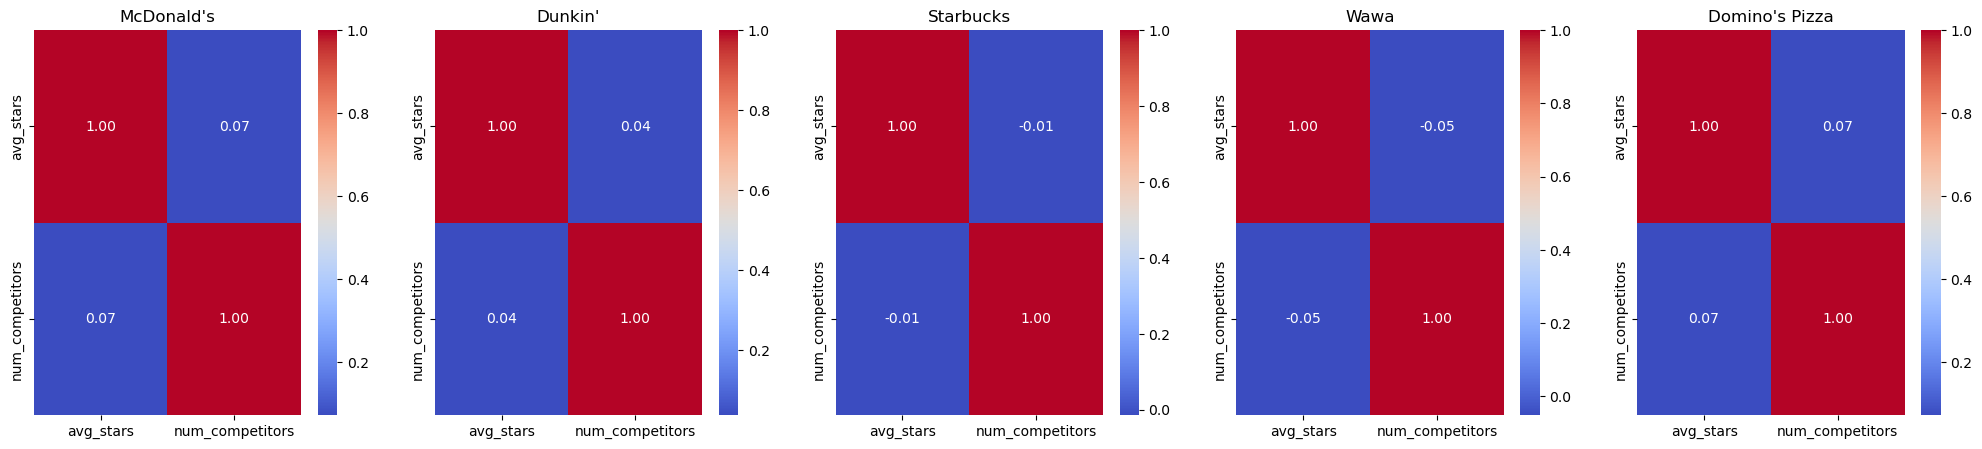

Variance of stars:


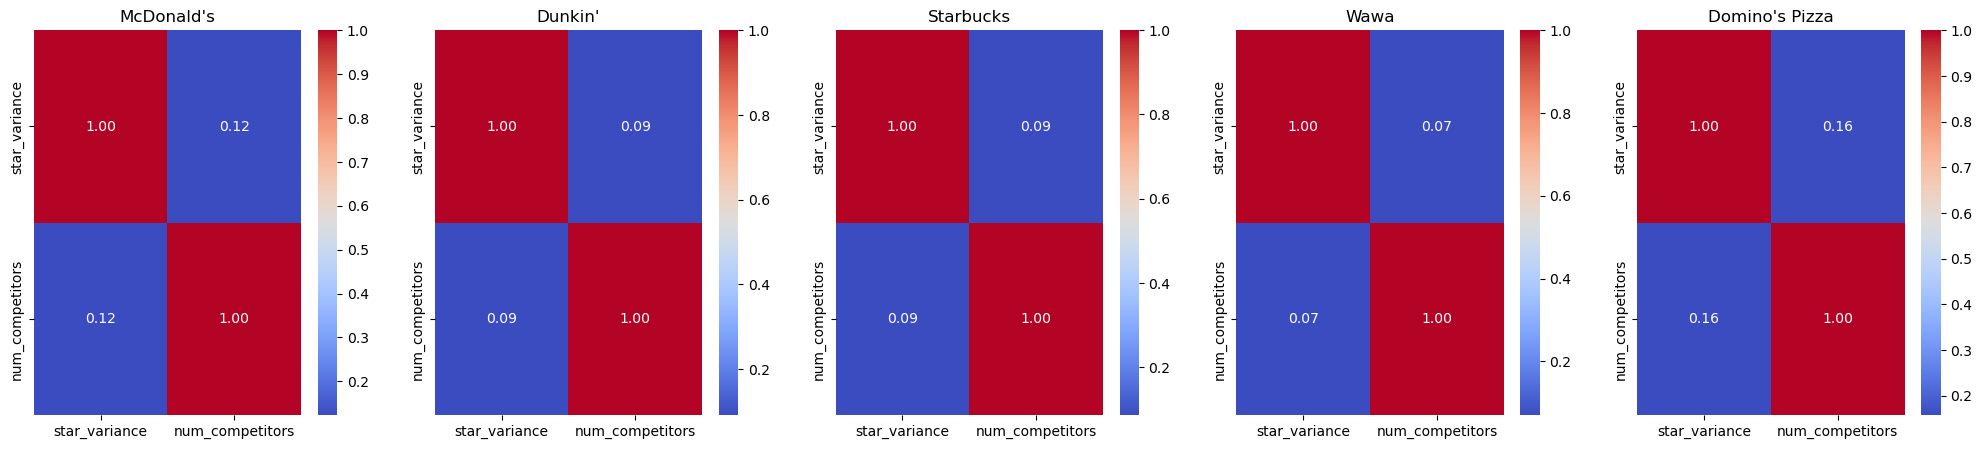

In [55]:
#Find the most widespread businesses
to_look_for = df.groupby("name").size().reset_index("name")
to_look_for.columns = ["name", "count"]
to_look_for = to_look_for.sort_values(by = "count", ascending = False)

#Consider only first 5 for plotting reasons
to_look_for = list(to_look_for["name"][:5])

fig, axs = plt.subplots(1, 5, figsize = (25, 5))

print("Average stars:")

for j in range(5):
    current_data = df[df["name"] == to_look_for[j]]
    
    correlation_matrix = current_data[["avg_stars", "num_competitors"]].corr()

    sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f", ax = axs[j])
    axs[j].set_title(to_look_for[j])

plt.show()

fig, axs = plt.subplots(1, 5, figsize = (25, 5))

print("Variance of stars:")

for j in range(5):
    current_data = df[df["name"] == to_look_for[j]]

    correlation_matrix = current_data[["star_variance", "num_competitors"]].corr()

    sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f", ax = axs[j])
    axs[j].set_title(to_look_for[j])

plt.show()

##### ***Query 5***
Discover if night reviews and day reviews are biased, that is show how the difference between their average values is distributed.

In [5]:
night_reviews = db["reviews"].aggregate([{
                                              "$project" : {
                                                  "user_id" : 1,
                                                  "date" : 1,
                                                  "stars" : 1
                                              }
                                         },
                                         {
                                              "$addFields" : {
                                                  "review_hour" : {
                                                      #"$hour" opeartor let us extract the hour from a date
                                                      "$hour": "$date"
                                                  }
                                              }
                                          },
                                          {
                                              #In this stage, we'are considering only the reviews written during the night
                                              "$match" : {
                                                  "$or" : [
                                                      {"review_hour" : {"$gte" : 22}},
                                                      {"review_hour" : {"$lte" : 5}}
                                                  ]
                                              }
                                          },
                                          {
                                              "$group" : {
                                                  "_id" : "$user_id",
                                                  "num_night_reviews" : {
                                                      "$sum" : 1
                                                  },
                                                  "avg_night_ratings" : {
                                                      "$avg" : "$stars"
                                                  }
                                              }
                                          },
                                          {
                                              "$project" : {
                                                  "_id" : 0,
                                                  "user_id" : "$_id",
                                                  "num_night_reviews" : 1,
                                                  "avg_night_ratings" : 1
                                              }
                                          }])

day_reviews = db["reviews"].aggregate([{
                                            "$project" : {
                                                "user_id" : 1,
                                                "date" : 1,
                                                "stars" : 1
                                            }
                                         },
                                         {
                                           "$addFields" : {
                                               "review_hour" : {
                                                   "$hour": "$date"
                                               }
                                           }
                                       },
                                       {
                                           "$match" : {
                                                #In this stage, we'are considering only the reviews written during the night
                                               "$and" : [
                                                     {"review_hour" : {"$lt" : 22}},
                                                     {"review_hour" : {"$gt" : 5}}
                                                 ]
                                           }
                                       },
                                       {
                                           "$group" : {
                                               "_id" : "$user_id",
                                               "num_day_reviews" : {
                                                   "$sum" : 1
                                               },
                                               "avg_day_ratings" : {
                                                   "$avg" : "$stars"
                                               }
                                           }
                                       },
                                       {
                                           "$project" : {
                                               "_id" : 0,
                                               "user_id" : "$_id",
                                               "num_day_reviews" : 1,
                                               "avg_day_ratings" : 1
                                           }
                                       }])

night_reviews = pd.DataFrame(night_reviews)
day_reviews = pd.DataFrame(day_reviews)

#Merge the two DFs basing on "user_id" column
df = pd.merge(day_reviews, night_reviews, on = "user_id", how = "inner")

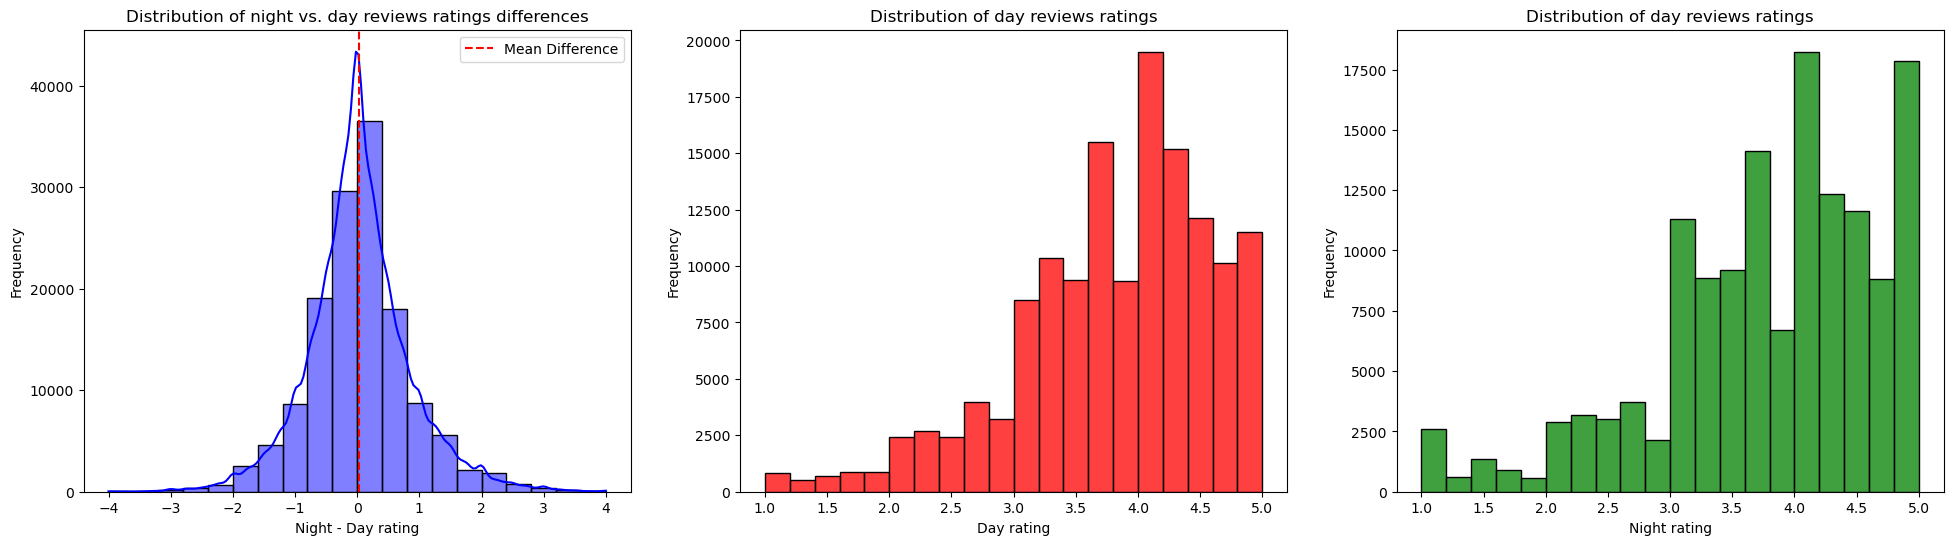

In [4]:
#Select a representative sample (users who have written at least 4 reviews in day hours and 2 in night hours)
repr = df.where((df["num_day_reviews"] >= 4) & 
                (df["num_night_reviews"] >= 2))

diff = repr["avg_day_ratings"] - repr["avg_night_ratings"]

fig, axs = plt.subplots(1, 3, figsize = (24, 6))

#Histogram for night - day reviews ratings
sns.histplot(diff, kde = True, bins = 20, color = "blue", ax = axs[0])
axs[0].axvline(diff.mean(), color = "red", linestyle = "--", label = "Mean Difference")
axs[0].set_title("Distribution of night vs. day reviews ratings differences")
axs[0].set_xlabel("Night - Day rating")
axs[0].set_ylabel("Frequency")
axs[0].legend()

#Histogram for night - day reviews ratings
sns.histplot(repr["avg_day_ratings"], color = "red", bins = 20, ax = axs[1])
axs[1].set_title("Distribution of day reviews ratings")
axs[1].set_xlabel("Day rating")
axs[1].set_ylabel("Frequency")

#Histogram for night - day reviews ratings
sns.histplot(repr["avg_night_ratings"], color = "green", bins = 20, ax = axs[2])
axs[2].set_title("Distribution of day reviews ratings")
axs[2].set_xlabel("Night rating")
axs[2].set_ylabel("Frequency")

plt.show()

In [16]:
#Same result can be obtained with the following query
query_results = db["reviews"].aggregate([{
                                              "$project" : {
                                                  "user_id" : 1,
                                                  "date" : 1,
                                                  "stars" : 1
                                              }
                                         },
                                         {
                                             "$addFields" : {
                                                 "reviewHour" : {
                                                     "$hour": "$date"
                                                 }
                                             }
                                         },
                                         {
                                             "$addFields" : { 
                                                 "is_night" : {
                                                     "$or" : [
                                                         {"$gte": ["$reviewHour", 22]}, 
                                                         {"$lt": ["$reviewHour", 5]}
                                                     ]
                                                 }
                                             }
                                         },
                                         { 
                                             "$group" : {
                                                 "_id" : "$user_id",
                                                 "num_night_reviews" : {
                                                     "$sum" : {
                                                         #"$cond" opeartor let us specify a if-then-else like condition. In thins case if "$is_night" == True, we sum 1 ($cond returns 1), otherwise 0
                                                         "$cond" : ["$is_night", 1, 0] 
                                                     }
                                                 },
                                                 "num_day_reviews" : {
                                                     "$sum" : {
                                                         "$cond" : ["$is_night", 0, 1]
                                                     }
                                                 },
                                                 "avg_night_ratings" : {
                                                     "$avg" : {
                                                         #When $avg is preseted with "None", it skips it
                                                         "$cond" : ["$is_night", "$stars", None] 
                                                     } 
                                                 },
                                                 "avg_day_ratings" : {
                                                     "$avg" : {
                                                         "$cond" : ["$is_night", None, "$stars"]
                                                     }
                                                 }
                                             }
                                         },
                                         { 
                                             "$match": {
                                                 "num_night_reviews" : {
                                                     "$gte": 4
                                                 },
                                                 "num_day_reviews" : {
                                                     "$gte": 4
                                                 },
                                             }
                                         },
                                         { 
                                             "$project" : {
                                                 "_id": 0,
                                                 "user_id": "$_id",
                                                 "num_night_reviews": 1,
                                                 "num_day_reviews": 1,
                                                 "avg_night_ratings": 1,
                                                 "avg_day_ratings": 1
                                             }
                                         }])

df = pd.DataFrame(query_results)
df

,num_night_reviews,num_day_reviews,avg_night_ratings,avg_day_ratings,user_id
0,8,20,5.000000,5.000000,---2PmXbF47D870stH1jqA
1,5,6,2.800000,4.333333,---UgP94gokyCDuB5zUssA
2,8,7,3.875000,3.857143,--3WaS23LcIXtxyFULJHTA
3,5,19,4.200000,4.263158,--4AjktZiHowEIBCMd4CZA
4,8,8,4.500000,5.000000,--B4MfqBxNuXX8ujyh8VXg
...,...,...,...,...,...
93720,4,11,4.000000,4.454545,zzqVInn9-mjoj7diZLFNkQ
93721,4,4,4.000000,5.000000,zzrhWsiCwAKQzbgMZIOtgg
93722,10,8,4.200000,3.875000,zzsPf8xNW11nd0B6MZqfRw
93723,18,24,4.611111,3.875000,zztkCqqgR6VntYbqio4UTQ


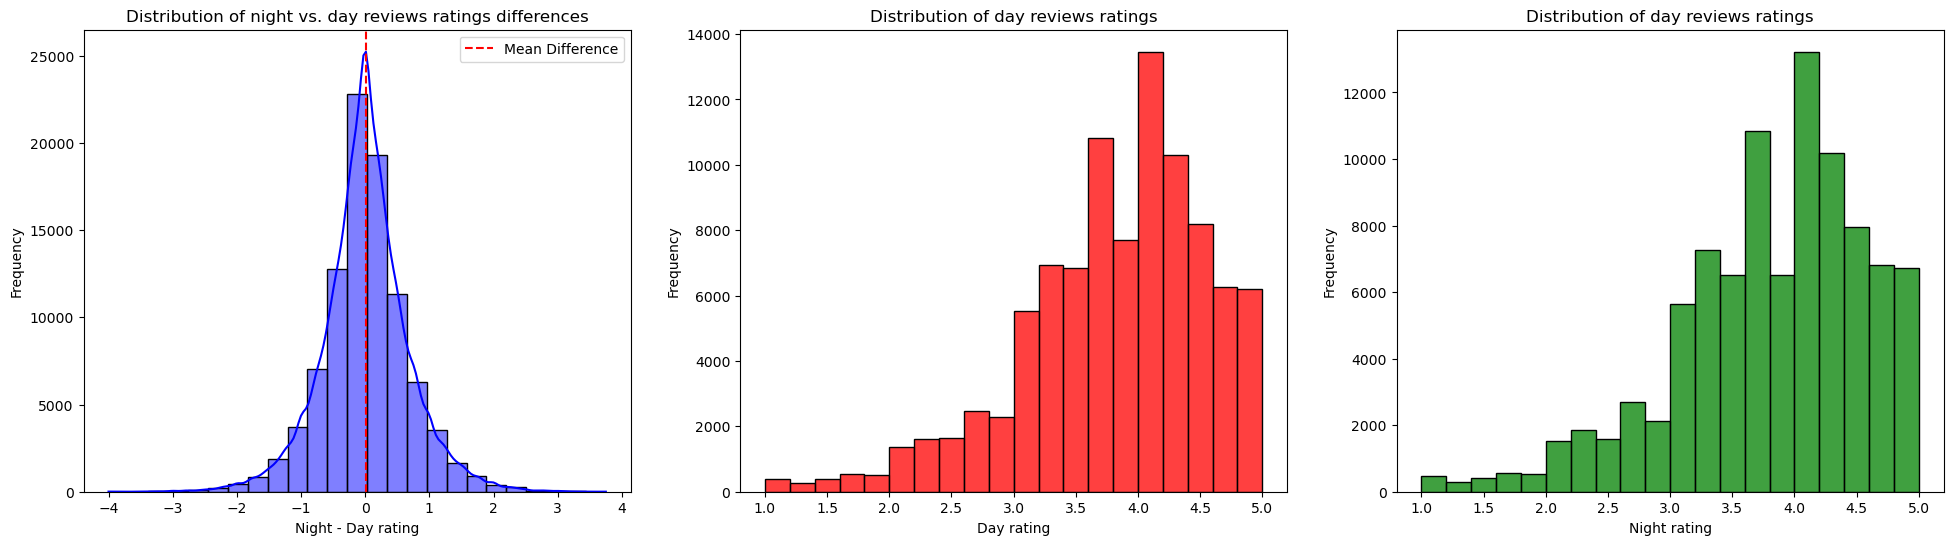

In [17]:
fig, axs = plt.subplots(1, 3, figsize = (24, 6))

diff = df["avg_day_ratings"] - df["avg_night_ratings"]

#Histogram for night - day reviews ratings
sns.histplot(diff, kde = True, bins = 25, color = "blue", ax = axs[0])
axs[0].axvline(diff.mean(), color = "red", linestyle = "--", label = "Mean Difference")
axs[0].set_title("Distribution of night vs. day reviews ratings differences")
axs[0].set_xlabel("Night - Day rating")
axs[0].set_ylabel("Frequency")
axs[0].legend()

#Histogram for night - day reviews ratings
sns.histplot(df["avg_day_ratings"], color = "red", bins = 20, ax = axs[1])
axs[1].set_title("Distribution of day reviews ratings")
axs[1].set_xlabel("Day rating")
axs[1].set_ylabel("Frequency")

#Histogram for night - day reviews ratings
sns.histplot(df["avg_night_ratings"], color = "green", bins = 20, ax = axs[2])
axs[2].set_title("Distribution of day reviews ratings")
axs[2].set_xlabel("Night rating")
axs[2].set_ylabel("Frequency")

plt.show()

##### ***Query 6***
Friends have similar ratings? For businesses they have both reviewed, compute the difference between their average ratings.

In [28]:
avg_rating = db["businesses_merged"].aggregate([{
                                                    "$unwind" : "$reviews"
                                                },
                                                {
                                                    "$group" : {
                                                        "_id" : {
                                                            "user_id" : "$reviews.user_id",
                                                            "business_id" : "$business_id"
                                                        },
                                                        "avg_rating" : {
                                                            "$avg" : "$reviews.stars"
                                                        }
                                                    }
                                                },
                                                {
                                                    "$match" : {
                                                        "avg_rating" : {
                                                            #"avg_rating" field must be not null
                                                            "$ne" : None
                                                        }
                                                    }
                                                },
                                                {
                                                    "$project" : {
                                                        "_id" : 0,
                                                        "user_id" : "$_id.user_id",
                                                        "business_id" : "$_id.business_id",
                                                        "avg_rating" : 1
                                                    }
                                                }])

common_reviewed = db["users_merged"].aggregate([{
                                                     "$project" : {
                                                         "user_id" : 1,
                                                         "reviews" : "$reviews.business_id",
                                                         "friends" : 1
                                                     }
                                                 },
                                                 {
                                                     "$lookup" : {
                                                         "from" : "users_merged",
                                                         "localField" : "friends",
                                                         "foreignField" : "user_id",
                                                         "pipeline" : [{
                                                             "$project" : {
                                                                 "user_id" : 1,
                                                                 "reviews" : "$reviews.business_id"
                                                             }
                                                         }],
                                                         "as" : "friend_reviews"
                                                     }
                                                 },
                                                 {
                                                     "$project" : {
                                                         "friends" : 0
                                                     }
                                                 },
                                                 {
                                                     "$addFields" : {
                                                         "shared_reviews" : {
                                                             #"$map" opeartor let us iterare over the field "friend_reviews" to create an object for friend
                                                             "$map" : {
                                                                 #"input" field is the field "friend_reviews"
                                                                 "input" : "$friend_reviews",
                                                                 #"as" operator let us create an alias (e.g. variable name) for input
                                                                 "as" : "f_r",
                                                                 #With "in" we're specifying what should be outputted for each element in the input array
                                                                 "in" : {
                                                                     #Put the currently analysed friend's id inside "friend_id". With "$$" we are accessing the variable in "f_r"
                                                                     "friend_id" : "$$f_r.user_id",
                                                                     #Common reviewed businesses
                                                                     "businesses" : {
                                                                         #"setIntersection" operator is used to find the intersection between two sets
                                                                         #"$$f_r.reviews" are the current businesses reviewed by the friend
                                                                         "$setIntersection" : ["$reviews", "$$f_r.reviews"]
                                                                     }
                                                                 }
                                                             }
                                                         }
                                                     }
                                                 },
                                                 {
                                                     "$project" : {
                                                         "reviews" : 0,
                                                         "friend_reviews" : 0
                                                     }
                                                 },
                                                 {
                                                     "$addFields" : {
                                                         "shared_reviews" : {
                                                             "$filter" : {
                                                                 "input" : "$shared_reviews",
                                                                 "as" : "s_r",
                                                                 "cond" : {
                                                                     "$gt": [{"$size": "$$s_r.businesses"}, 0]
                                                                 }
                                                             }
                                                         }
                                                     }
                                                 },
                                                 {
                                                     "$unwind" : "$shared_reviews"
                                                 },
                                                 {
                                                     "$project": {
                                                         "_id" : 0,
                                                         "user_id" : 1,
                                                         "shared_reviews" : 1
                                                     }
                                                 }])

#common_reviewed = pd.DataFrame(common_reviewed)
avg_rating = pd.DataFrame(avg_rating)
avg_rating

,avg_rating,user_id,business_id
0,5.0,---1lKK3aKOuomHnwAkAow,f19eLfhXqR47Ct8Hz2y_pA
1,5.0,---2PmXbF47D870stH1jqA,0ZsqqzHu1HHkDdIKoivi5g
2,5.0,---2PmXbF47D870stH1jqA,1An4DxtMmvvSe0HX4viRCA
3,5.0,---2PmXbF47D870stH1jqA,3YqUe2FTCQr0pPVK8oCv6Q
4,5.0,---2PmXbF47D870stH1jqA,3gXgILE2YWVidJDvVWBT6Q
...,...,...,...
6745722,4.0,zzz-M4QvkEpUWWPL9RTzLA,qO-r-NipYXcuVXjIbaglEQ
6745723,5.0,zzzCg-_lpyYE82TlJCdwdw,LttC5xNMFcgOg3bt_MlXTg
6745724,3.0,zzzGgfvrSJ4AQeKtcgocIw,XyYsl2OyoMi6OMvzsdcVoQ
6745725,1.0,zzzMBVS73g3ZJ7qL8JyhiA,3FKIev7ZB_KE6XHL9sUJCg


In [26]:
avg_rating_dict = avg_rating.reset_index()\
                            .groupby("user_id")\
                            .apply(lambda g: dict(zip(g["business_id"], g["avg_rating"])))\
                            .to_dict()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_17404\879905455.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: dict(zip(g["business_id"], g["avg_rating"])))\


In [29]:
#Attention: it might take long!

result = []

for doc in common_reviewed:
    #Remeber that each document in common_reviewed is JSON (so a dict)...
    user_id = doc["user_id"]
    
    #and we have put inside it another dict
    friend_id = doc["shared_reviews"]["friend_id"]
    businesses = doc["shared_reviews"]["businesses"]
    
    #We are retreiving ratings directly from the dictionary
    avg_user_ratings = [avg_rating_dict[user_id][b] for b in businesses]
    avg_friend_ratings = [avg_rating_dict[user_id][b] for b in businesses]
    
    result.append({
        "user_id" : user_id,
        "friend_id" : friend_id,
        "avg_rating_user" : pd.Series(avg_user_ratings).mean(),
        "avg_rating_friend" : pd.Series(avg_friend_ratings).mean()
    })
    
result_df = pd.DataFrame(result)
result_df

,user_id,friend_id,avg_rating_user,avg_rating_friend
0,qVc8ODYU5SZjKXVBgXdI7w,-0SqALqeWmInVftG_iHcHg,5.0,5.0
1,qVc8ODYU5SZjKXVBgXdI7w,-vQsYbUmdtL9GB3z3ZG0tw,4.0,4.0
2,qVc8ODYU5SZjKXVBgXdI7w,0m-7A68bctvAHXPhMEazTg,5.0,5.0
3,qVc8ODYU5SZjKXVBgXdI7w,0yYCMhDWCEIVUyZLzDWwqQ,5.0,5.0
4,qVc8ODYU5SZjKXVBgXdI7w,1JLeCtVa2-i7aH5aC4bF2w,5.0,5.0
...,...,...,...,...
1067665,Wq2ZxDUbOMmuSQIWGPC60A,4xpo1s-gb9SeJg4ppSzobA,4.0,4.0
1067666,Un9IgydB67um2VtC6TvvVw,iu4cazC32xlyUcFBSYWgCA,1.0,1.0
1067667,qMD-Qxw7ntTHnAkGMiNv5A,WB1ZKk3CnF3j7_QjLyQoxA,1.0,1.0
1067668,n8YZ-f_4waehfbmEb0lA1w,WwulXySQN8t2hwqH_yWurA,5.0,5.0


<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_35572\1221804631.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta$ rewievs stars")


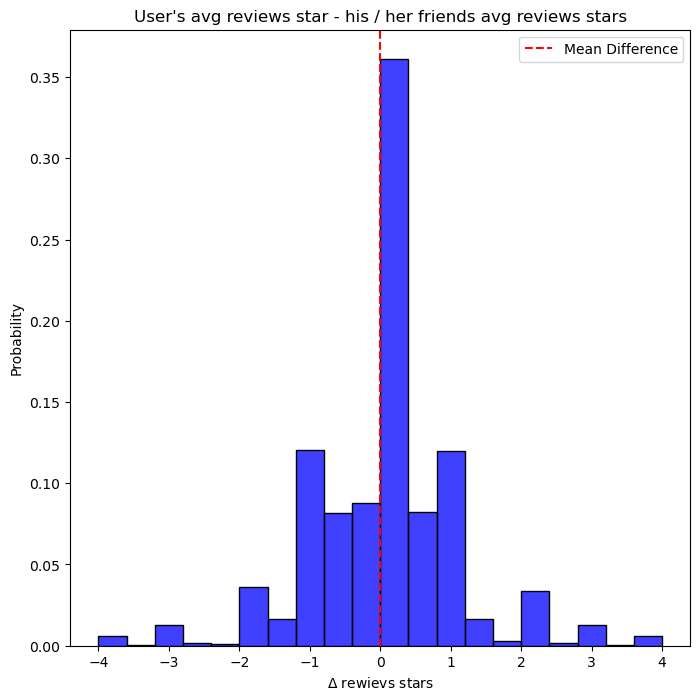

In [ ]:
fig = plt.figure(figsize = (8, 8))

diff = result_df["avg_rating_user"] - result_df["avg_rating_friend"]

sns.histplot(diff, bins = 20, color = "blue", stat = "probability")
plt.axvline(diff.mean(), color = "red", linestyle = "--", label = "Mean Difference")
plt.title("User's avg reviews star - his / her friends avg reviews stars")
plt.xlabel("$\Delta$ rewievs stars")
plt.ylabel("Probability")
plt.legend()

##### ***Query 7***
Find businesses that have increased / decreased the number of checkins in a specific time horizon. Determine, also, the number of reviews and their average stars in that time horizon.

In [ ]:
start = 2010
end = 2020

yearly_checkins = db["businesses_merged"].aggregate([{
                                                         "$unwind" : "$checkins"
                                                     },
                                                     {
                                                         "$addFields" : {
                                                             "year_checkin" : {
                                                                 "$year" : "$checkins"
                                                             }
                                                         }
                                                     },
                                                     {
                                                         "$match" : {
                                                             "$and" : [{"year_checkin" : {"$gte" : start}}, 
                                                                       {"year_checkin" : {"$lte" : end}}]
                                                         }
                                                     },
                                                     {
                                                         "$group" : {
                                                             "_id" : {
                                                                 "name" : "$name",
                                                                 "city" : "$city",
                                                                 "year" : "$year_checkin"
                                                             },
                                                             "num_checkins" : {
                                                                 "$sum" : 1
                                                             }
                                                         }
                                                     },
                                                     {
                                                         "$sort" : {
                                                             "_id.name" : 1,
                                                             "_id.city" : 1,
                                                             "_id.year" : 1
                                                         }
                                                     },
                                                     {
                                                         "$group" : {
                                                             "_id" : {
                                                                 "name" : "$_id.name",
                                                                 "city" : "$_id.city"
                                                             },
                                                             "checkins_sequence" : {
                                                                 #"push" operator is used to insert an object (or a set of fields) in an array
                                                                 "$push" : {
                                                                     "year" : "$_id.year",
                                                                     "num_checkins" : "$num_checkins"
                                                                 }
                                                             }
                                                         }
                                                     },
                                                     {
                                                         "$project" : {
                                                             "_id" : 0,
                                                             "name" : "$_id.name",
                                                             "city" : "$_id.city",
                                                             "checkins_sequence" : 1
                                                         }
                                                     }])

yearly_reviews = db["businesses_merged"].aggregate([{
                                                        "$unwind" : "$reviews"
                                                    },
                                                    {
                                                         "$addFields" : {
                                                             "year_review" : {
                                                                 #"year" operator is used to extract the year from a date
                                                                 "$year" : "$reviews.date"
                                                             }
                                                         }
                                                     },
                                                     {
                                                         "$match" : {
                                                             "$and" : [{"year_review" : {"$gte" : start}}, 
                                                                       {"year_review" : {"$lte" : end}}]
                                                         }
                                                     },
                                                     {
                                                         "$group" : {
                                                             "_id" : {
                                                                 "name" : "$name",
                                                                 "city" : "$city",
                                                                 "year" : "$year_review"
                                                             },
                                                             "num_checkins" : {
                                                                 "$sum" : 1
                                                             },
                                                             "avg_rating" : {
                                                                 "$avg" : "$reviews.stars"
                                                             }
                                                         }
                                                     },
                                                     {
                                                         "$sort" : {
                                                             "_id.name" : 1,
                                                             "_id.city" : 1,
                                                             "_id.year" : 1
                                                         }
                                                     },
                                                     {
                                                         "$group" : {
                                                             "_id" : {
                                                                 "name" : "$_id.name",
                                                                 "city" : "$_id.city"
                                                             },
                                                             "reviews_sequence" : {
                                                                 "$push" : {
                                                                     "year" : "$_id.year",
                                                                     "num_reviews" : "$num_reviews",
                                                                     "avg_rating" : "$avg_rating"
                                                                }
                                                             }
                                                         }
                                                     },
                                                     {
                                                         "$project" : {
                                                             "_id" : 0,
                                                             "name" : "$_id.name",
                                                             "city" : "$_id.city",
                                                             "reviews_sequence" : 1
                                                         }
                                                     }])

yearly_checkins = list(yearly_checkins)
yearly_reviews = {(doc["name"], doc["city"]) : doc["reviews_sequence"] for doc in yearly_reviews}

In [ ]:
#Takes a sequence of (years - checkins), checks if years are consecutive and filters on "growth_rate"
def calculate_and_filter_trend(sequence, filter):
    #Retain only the businesses with consecutive years in "sequence"
    window = [s["year"] for s in sequence]
    for i in range(len(window) - 1):
        if window[i + 1] - window[i] != 1:
            return None

    growth = []

    for i in range(1, len(sequence)):
        curr = sequence[i]
        prev = sequence[i - 1]

        growth_rate = (curr["num_checkins"] - prev["num_checkins"]) / prev["num_checkins"]

        if not filter(growth_rate):
            return None

        growth.append({
            "year" : curr["year"],
            "growth" : curr["num_checkins"] - prev["num_checkins"],
            "growth_rate" : growth_rate
        })

    return growth

In [149]:
#Process with Python function and filter the result
filter = lambda x : x >= 0.1 #This means: "reatin all businesses with growth rate of at least +0.1"
for doc in yearly_checkins:
    doc["checkins_trend"] = calculate_and_filter_trend(doc["checkins_sequence"], filter)

yearly_checkins = [doc for doc in yearly_checkins if doc["checkins_trend"]]

#Now, combine with the reviews
for doc in yearly_checkins:
    if (doc["name"],  doc["city"]) in yearly_reviews.keys():
        years = [x["year"] for x in doc["checkins_trend"]]
        doc["reviews_trend"] = [x for x in yearly_reviews[(doc["name"],  doc["city"])] if x["year"] in years]

#Final result
yearly_checkins[6]

{'checkins_sequence': [{'year': 2011, 'num_checkins': 37},
  {'year': 2012, 'num_checkins': 83},
  {'year': 2013, 'num_checkins': 100},
  {'year': 2014, 'num_checkins': 118}],
 'name': '168 Chinese & Sushi',
 'city': 'Reno',
 'checkins_trend': [{'year': 2012,
   'growth': 46,
   'growth_rate': 1.2432432432432432},
  {'year': 2013, 'growth': 17, 'growth_rate': 0.20481927710843373},
  {'year': 2014, 'growth': 18, 'growth_rate': 0.18}],
 'reviews_trend': [{'year': 2012, 'avg_rating': 4.146341463414634},
  {'year': 2013, 'avg_rating': 3.857142857142857},
  {'year': 2014, 'avg_rating': 3.5576923076923075}]}

In [158]:
#We'll use a function to not duplicate code across different plots
def plot(dict_to_plot):
    #Extracting data
    years_checkins = [item["year"] for item in dict_to_plot["checkins_sequence"]]
    num_checkins = [item["num_checkins"] for item in dict_to_plot["checkins_sequence"]]

    years_growth = [item["year"] for item in dict_to_plot["checkins_trend"]]
    growth_rates = [item["growth_rate"] for item in dict_to_plot["checkins_trend"]]

    years_ratings = [item["year"] for item in dict_to_plot["reviews_trend"]]
    avg_ratings = [item["avg_rating"] for item in dict_to_plot["reviews_trend"]]

    plt.figure(figsize=(15, 5))

    #Plot for num_checkins
    plt.subplot(1, 3, 1)
    sns.barplot(x = years_checkins, y = num_checkins, color = "blue", )
    plt.title("Yearly number of checkins")
    plt.xlabel("Year")
    plt.ylabel("Number of Cceckins")

    #Plot for growth_rate
    plt.subplot(1, 3, 2)
    sns.barplot(x = years_growth, y = growth_rates, color = "green")
    plt.title("Yearly growth rate")
    plt.xlabel("Year")
    plt.ylabel("Growth rate")

    #Plot for avg_rating
    plt.subplot(1, 3, 3)
    sns.barplot(x = years_ratings, y = avg_ratings, color = "red")
    plt.title("Yearly average ratings")
    plt.xlabel("Year")
    plt.ylabel("Average rating")

    plt.tight_layout()
    plt.show()

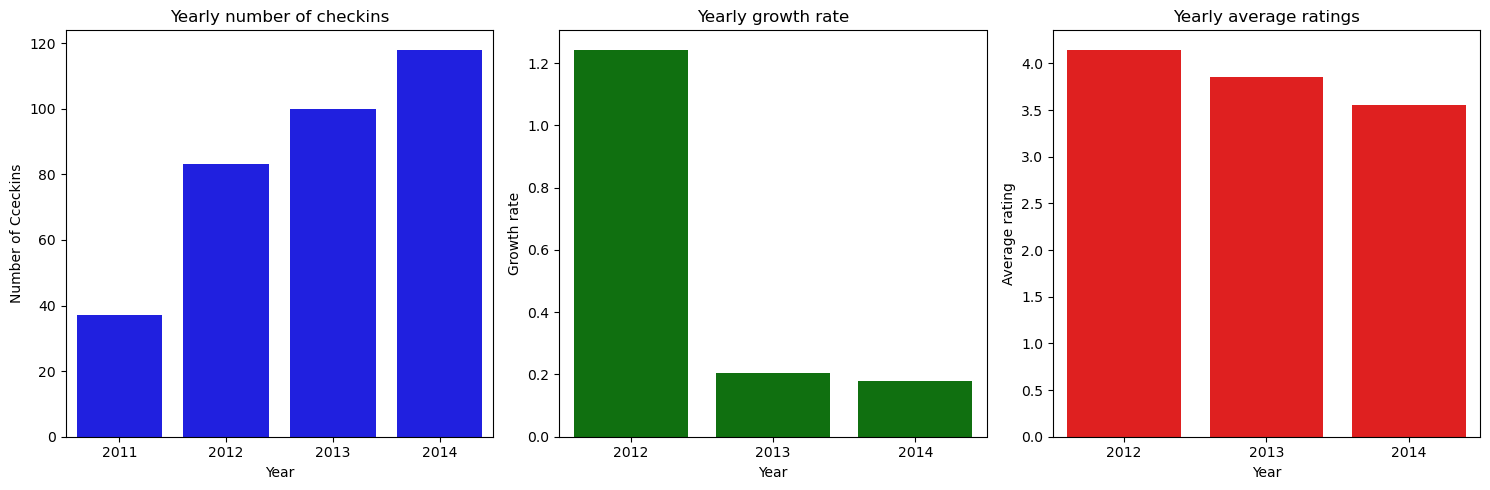

In [159]:
#Plot one random dict of "yearly_checkins" list
plot(dict_to_plot = yearly_checkins[6])

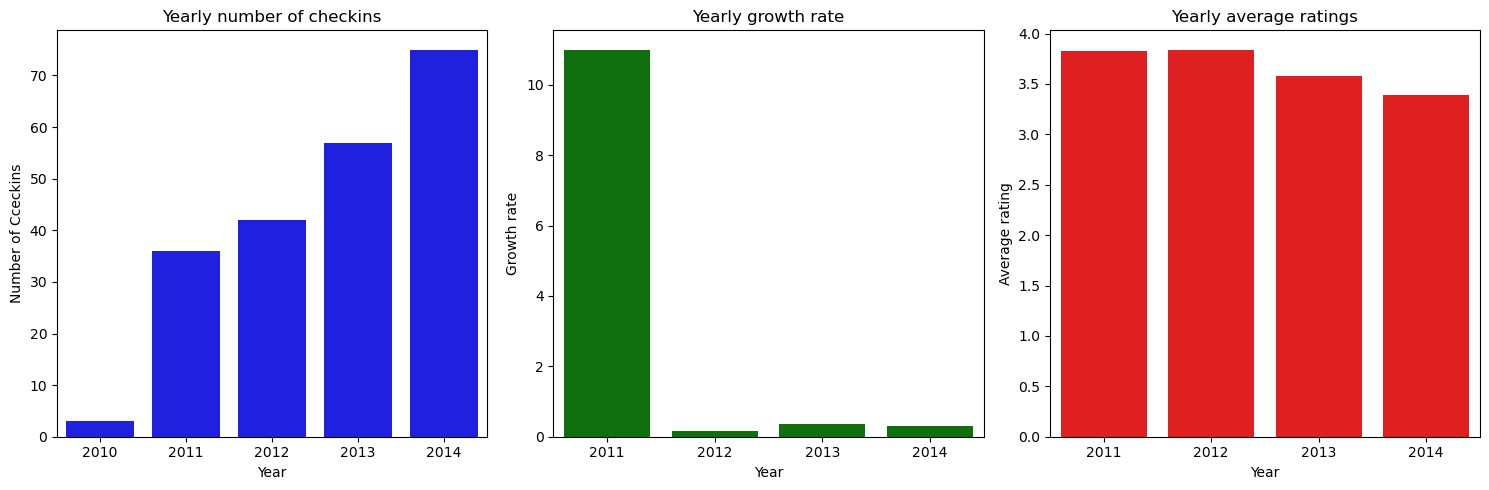

In [ ]:
sequences = [(index, item.get("checkins_sequence", [])) for index, item in enumerate(yearly_checkins)]
sequences = [(index, len(item[1])) for index, item in enumerate(sequences)] 
df = pd.DataFrame(sequences, columns = ["index", "length"])

#Sort by sequence length in descending order and pick top 5
top_indices = df.sort_values("length", ascending = False).head(5)["index"]

#Retrieve the corresponding dictionaries
top_dicts = [yearly_checkins[i] for i in top_indices]

#Plot for one of top-5
plot(top_dicts[4])

##### ***Query 8***
For each category, we'll determine in which city reviews' sentiment is the lowest (i.e. the qulity is ). To have a less biased result, we'll consider only categories with sufficient number of positive and negative reviews (at least 50 for each one).

In [47]:
query_results = db["businesses_merged"].aggregate([{
                                                       "$unwind": "$reviews"
                                                   },
                                                   {
                                                       "$unwind" : "$categories" 
                                                   },
                                                   {
                                                       "$group" : {
                                                           "_id" : {
                                                               "city" : "$city",
                                                               "category": "$categories"
                                                           },
                                                           "num_positive_reviews" : {
                                                               "$sum" : {
                                                                   "$cond" : [{"$eq" : ["$reviews.sentiment", "positive"]}, 1, 0]
                                                               }
                                                           },
                                                           "num_negative_reviews" : {
                                                               "$sum" : {
                                                                   "$cond" : [{"$eq" : ["$reviews.sentiment", "negative"]}, 1, 0]
                                                               }
                                                           }
                                                       }
                                                   },
                                                   {
                                                       "$match" : {
                                                           "num_positive_reviews" : {
                                                               "$gte": 50
                                                           },
                                                           "num_negative_reviews" : {
                                                               "$gte" : 50
                                                           }
                                                       }
                                                   },
                                                   {
                                                       "$addFields" : {
                                                           "neg_to_pos_ratio" : {
                                                               #"divide" operator let use divide two numbers
                                                               "$divide" : ["$num_negative_reviews", "$num_positive_reviews"]
                                                           }
                                                       }
                                                   },
                                                   {
                                                       "$sort" : {
                                                           "city" : 1,
                                                           "name" : 1,
                                                           "neg_to_pos_ratio" : -1
                                                       }
                                                   },
                                                   {
                                                       "$project" : {
                                                           "_id" : 0,
                                                           "city" : "$_id.city",
                                                           "category" : "$_id.category",
                                                           "tot_reviews" : {
                                                               "$sum" : ["$num_positive_reviews", "$num_negative_reviews"]
                                                           },
                                                           "num_negative_reviews" : 1,
                                                           "num_positive_reviews" : 1,
                                                           "neg_to_pos_ratio" : 1
                                                       }
                                                   }])

categories = pd.DataFrame(query_results)
categories

,num_positive_reviews,num_negative_reviews,neg_to_pos_ratio,city,category,tot_reviews
0,55,696,12.654545,Tampa,Internet Service Providers,751
1,86,710,8.255814,Ballwin,Appliances & Repair,796
2,62,475,7.661290,Wilmington,Financial Services,537
3,86,610,7.093023,Indianapolis,Security Systems,696
4,92,640,6.956522,Philadelphia,Television Service Providers,732
...,...,...,...,...,...,...
18684,1055,88,0.083412,New Orleans,Food Tours,1143
18685,1501,107,0.071286,New Orleans,Art Tours,1608
18686,2813,195,0.069321,Santa Barbara,Wine Tours,3008
18687,743,50,0.067295,Marrero,Tours,793


In [48]:
#Find a category that is in categories at least 15 times
grouped = categories.drop(labels = ["tot_reviews", "num_negative_reviews", "num_positive_reviews", "neg_to_pos_ratio"], axis = 1)\
                    .groupby(by = "category")\
                    .size()\
                    .reset_index("category")

grouped.columns = ["category", "count"]
grouped = grouped.sort_values(by = "count", ascending = False).set_index("category")
res = grouped[grouped["count"] >= 15].index[:3]

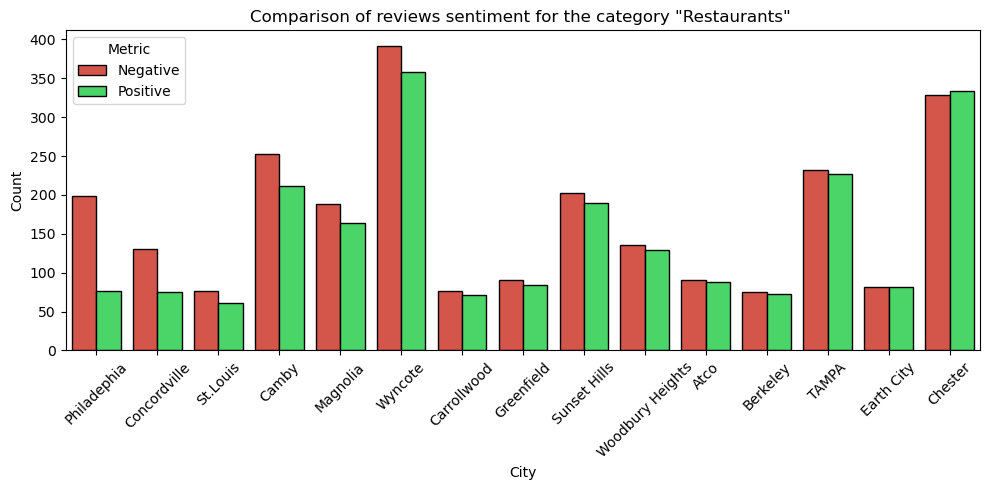

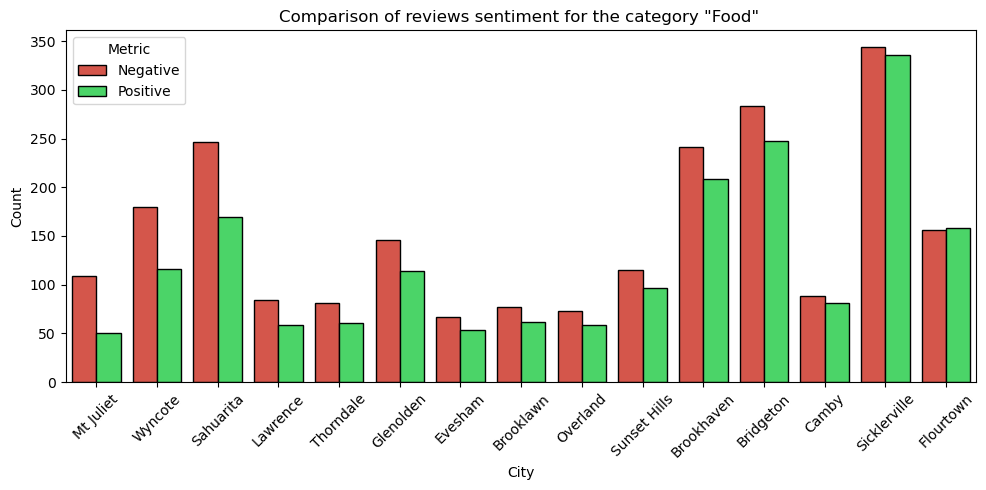

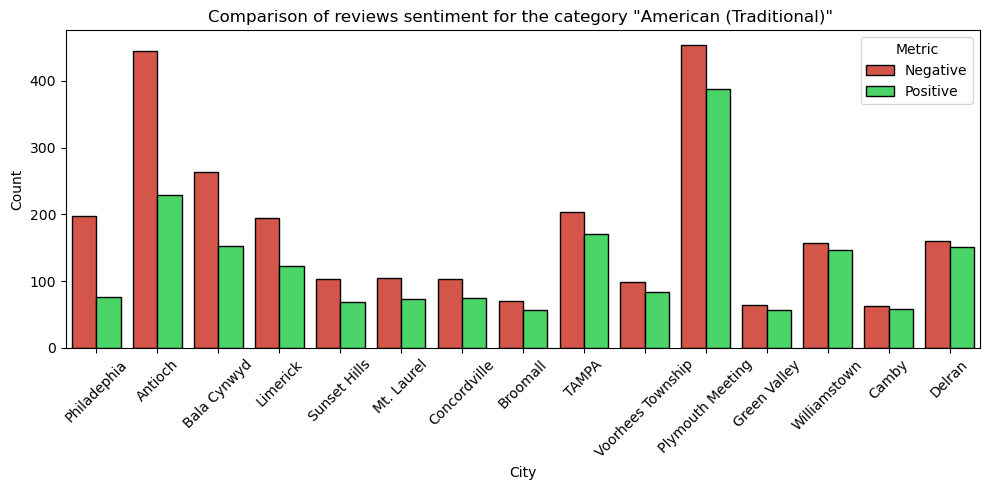

In [49]:
metrics = ["num_negative_reviews", "num_positive_reviews"]
colors = ["#eb4334", "#34eb5b"]

for i in range(3): 
    category_res_df = categories[categories["category"] == res[i]][:15]
    
    #Transform data for grouped bar plot
    melted_df = category_res_df.melt(id_vars = ["city"], value_vars = metrics, var_name = "metric", value_name = "count")
    
    fig, ax = plt.subplots(figsize = (10, 5))

    bars = sns.barplot(data = melted_df, x = "city", y = "count", hue = "metric", palette = colors, ax = ax)

    for bar in bars.patches:
        bar.set_edgecolor('black')
        bar.set_linewidth(1)

    ax.set_title(f"""Comparison of reviews sentiment for the category "{res[i]}" """)

    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles = handles, title = "Metric", labels = ["Negative", "Positive"])

    ax.set_xlabel("City")
    ax.set_ylabel("Count")
    ax.tick_params(axis = "x", rotation = 45)

    plt.tight_layout()
    plt.show()

    print("\n")

##### ***Query 9***
Determine the relation between number of reviews and average stars value. Count for each bucket $[r_i, r_{i+1})$ the businesses with average reviews stars in it.

In [ ]:
#In this query, we'll use the "$bucket" operator that expects an array of number specyfing the boundaries of each bucket.
#By default the boundaries are interpreted as: b[i] <= x < b[i + 1], so avg = 0 or avg = 5 would go in "other" bucket. To avoid this, we extend the bounds (0 <= avg <= 5)
step = 0.5
boundaries = [-0.1] + [0.5 * x for x in range(0, 11)] + [5.1]

avg_reviews_stars = db["businesses_merged"].aggregate([{
                                                           "$project" : {
                                                               "business_id" : 1,
                                                               "reviews.stars" : 1
                                                           }
                                                       },
                                                       {
                                                           "$unwind" : "$reviews"
                                                       },
                                                       {
                                                           "$group" : {
                                                               "_id" : "$business_id",
                                                               "avg_rating" : {
                                                                   "$avg" : "$reviews.stars"
                                                               },
                                                               "num_reviews" : {
                                                                   "$sum" : 1
                                                               }
                                                           }
                                                       },
                                                       {
                                                           "$match" : {
                                                               "num_reviews" : {
                                                                   "$gte" : 25 #To have a less-biased result, we'll consider businesses with at least 50 reviews
                                                               }
                                                           }
                                                       },
                                                       {
                                                           #"$bucket" stage is used when you need to count how many values are within some ranges
                                                           "$bucket" : {
                                                               #We put in each bucket the average rating
                                                               "groupBy" : "$avg_rating",
                                                               #Each buchet has the voundaries defined above
                                                               "boundaries" : boundaries,
                                                               #In "default" bucket all avg_rating not in boundaries are put (in this case it will be empty)
                                                               "default" : "other",
                                                               "output" : {
                                                                   #We'll count the number of businesses for each bucket
                                                                   "count" : {
                                                                       "$sum" : 1
                                                                   }
                                                               }
                                                           }
                                                       },
                                                       {
                                                           #There might be cases where we don't have all buckets (for example the [0, 0.5) one), but in the plot we need all of them, so we densify the documents
                                                           "$densify" : {
                                                               #We apply densification on "_id" field
                                                               "field" : "_id",
                                                               #The "_id"s resulting documents must cover enterely [0.5, ..., 4.5, 5] range
                                                               "range" : {
                                                                   "step" : step,
                                                                   "bounds" : [0.5, 5.0 + 0.5]
                                                               }
                                                           }
                                                       },
                                                       {
                                                           #For the only documents that have been densified, we set the "count" to 0
                                                           "$set" : {
                                                               "count" : {
                                                                   "$cond" : [{"$not" : ["$count"]}, 0, "$count"]
                                                               }
                                                           }
                                                       },
                                                       {
                                                           "$project" : {
                                                               "boundary" : "$_id", #This value will be the upper bound of the bucket (e.g. 1.0 stands for bucket [0.5, 1))
                                                               "_id" : 0,
                                                               "count" : 1
                                                           }
                                                       }])

avg_reviews_stars = pd.DataFrame(avg_reviews_stars)
avg_reviews_stars

,count,boundary
0,0,0.5
1,630,1.0
2,1730,1.5
3,3278,2.0
4,5370,2.5
5,8925,3.0
6,13369,3.5
7,13638,4.0
8,6638,4.5
9,275,5.0


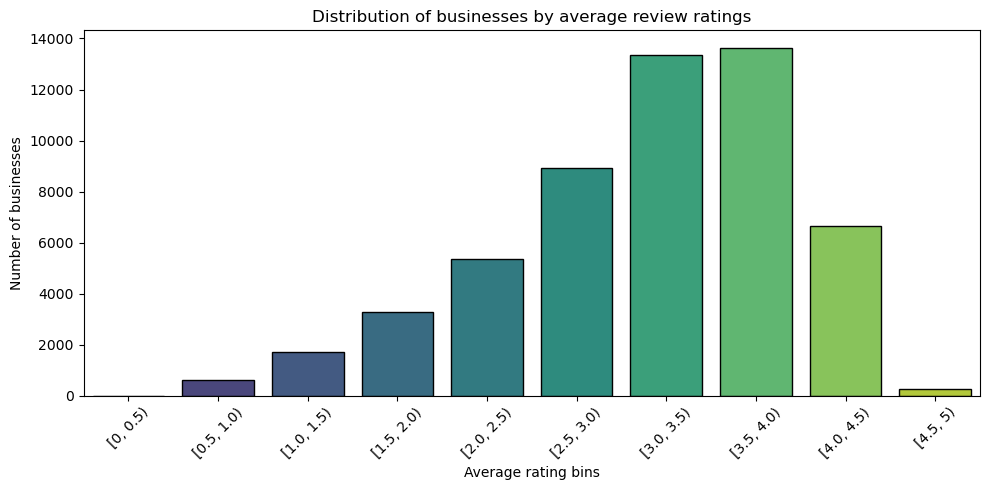

In [91]:
boundaries =  [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5]
bins = [f"[{boundaries[i]}, {boundaries[i + 1]})" for i in range(0, len(boundaries) - 1)]
plt.figure(figsize = (10, 5))
sns.barplot(x = bins, y = avg_reviews_stars["count"], palette = "viridis", hue = bins, legend = False, edgecolor = "black")
plt.xlabel("Average rating bins")
plt.ylabel("Number of businesses")
plt.title("Distribution of businesses by average review ratings")
plt.xticks(rotation = 45)
plt.tight_layout()

##### ***Query 10***
Study the relation between sentiment and stars of reviews. For each star value, count the number of reviews with positive and negative sentiments. Then, compute the minimum confidence $m=\min_i\,\,\text{confidence}_i$ and $M=\max_i \,\, \text{confidence}_i$. Define:
$$\left[m, m + \frac14(M-m), m+\frac12(M-m), m+\frac34(M-m), M\right]$$
For each star and bin, count the number of reviews with the that number of stars and confidence in that bin. 

In [ ]:
min_max_confidence = db["reviews"].aggregate([{
                                                  "$project" : {
                                                      "_id" : 1,
                                                      "confidence" : 1
                                                  }
                                              },
                                              {
                                                  "$group" : {
                                                      "_id" : True,
                                                      "max_confidence" : {
                                                          "$max" : "$confidence"
                                                      },
                                                      "min_confidence" : {
                                                          "$min" : "$confidence"
                                                      }
                                                  }
                                              },
                                              {
                                                  "$project" : {
                                                      "_id" : 0
                                                  }
                                              }])

min_max_confidence = pd.DataFrame(min_max_confidence)
min_confidence, max_confidence = min_max_confidence["min_confidence"][0], min_max_confidence["max_confidence"][0]
interval = max_confidence - min_confidence
bins = [min_confidence, min_confidence + interval / 4.0, min_confidence + interval / 2.0, min_confidence + 3.0 / 4.0 * interval, max_confidence]

#We need to count the number of reviews for each bin, so we in "group" stage we need:
#"bin_n": {
#    "$sum" : {
#        "$cond" : {
#            "if" : {
#                "$and" : [
#                    {"$gte" : ["$confidence", bins[i]]},
#                    {"$lte" : ["$confidence", bins[i + 1]]}
#                ]
#            },
#            "then" : 1,
#            "else" : 0
#        }
#    }
#}
#This makes the query unnecessarily long and complex, so we create a dict "bin_fields" where each bin is mapped to its 
#sub-query to be performed "group" stage:
bins_fields = {
    f"bin_{i + 1}": {
        "$sum" : {
            "$cond" : {
                "if" : {
                    "$and" : [
                        {"$gte" : ["$confidence", bins[i]]},
                        {"$lte" : ["$confidence", bins[i + 1]]}
                    ]
                },
                "then" : 1,
                "else" : 0
            }
        }
    }
    for i in range(4)
}

query_results = db["reviews"].aggregate([{
                                              "$project" : {
                                                  "sentiment" : 1,
                                                  "confidence" : 1,
                                                  "stars" : 1
                                              }
                                          },
                                          {
                                              "$group" : {
                                                  "_id" : {
                                                      "stars" : "$stars",
                                                      "sentiment" : "$sentiment"
                                                  },
                                                  "num_reviews" : {
                                                      "$sum" : 1
                                                  },
                                                  #Withint the query, we can use dict unpacking (** operator) to merge the binning in the "group" stage
                                                  **bins_fields
                                              }
                                          },
                                          {
                                              "$project" : {
                                                  "stars" : "$_id.stars",
                                                  "sentiment" : "$_id.sentiment",
                                                  "_id" : 0,
                                                  "max_confidence" : 1,
                                                  "min_confidence" : 1,
                                                  "bin_1" : 1,
                                                  "bin_2" : 1, 
                                                  "bin_3" : 1,
                                                  "bin_4" : 1,
                                                  "num_reviews": 1
                                              }
                                          }])

sentiment_vs_stars = pd.DataFrame(query_results)
sentiment_vs_stars

,num_reviews,bin_1,bin_2,bin_3,bin_4,stars,sentiment
0,1013635,4514,5835,9713,993680,1,negative
1,345863,9665,11760,18706,305931,3,negative
2,1259600,10593,12917,21023,1215289,4,positive
3,456246,5240,6547,11243,433329,2,negative
4,55915,4130,4559,6310,40989,1,positive
5,3065884,10369,12838,21359,3021536,5,positive
6,193316,10358,12123,17959,153098,4,negative
7,165723,10071,11164,16784,127873,5,negative
8,346071,9734,11129,17400,308004,3,positive
9,87994,5028,5527,8228,69315,2,positive


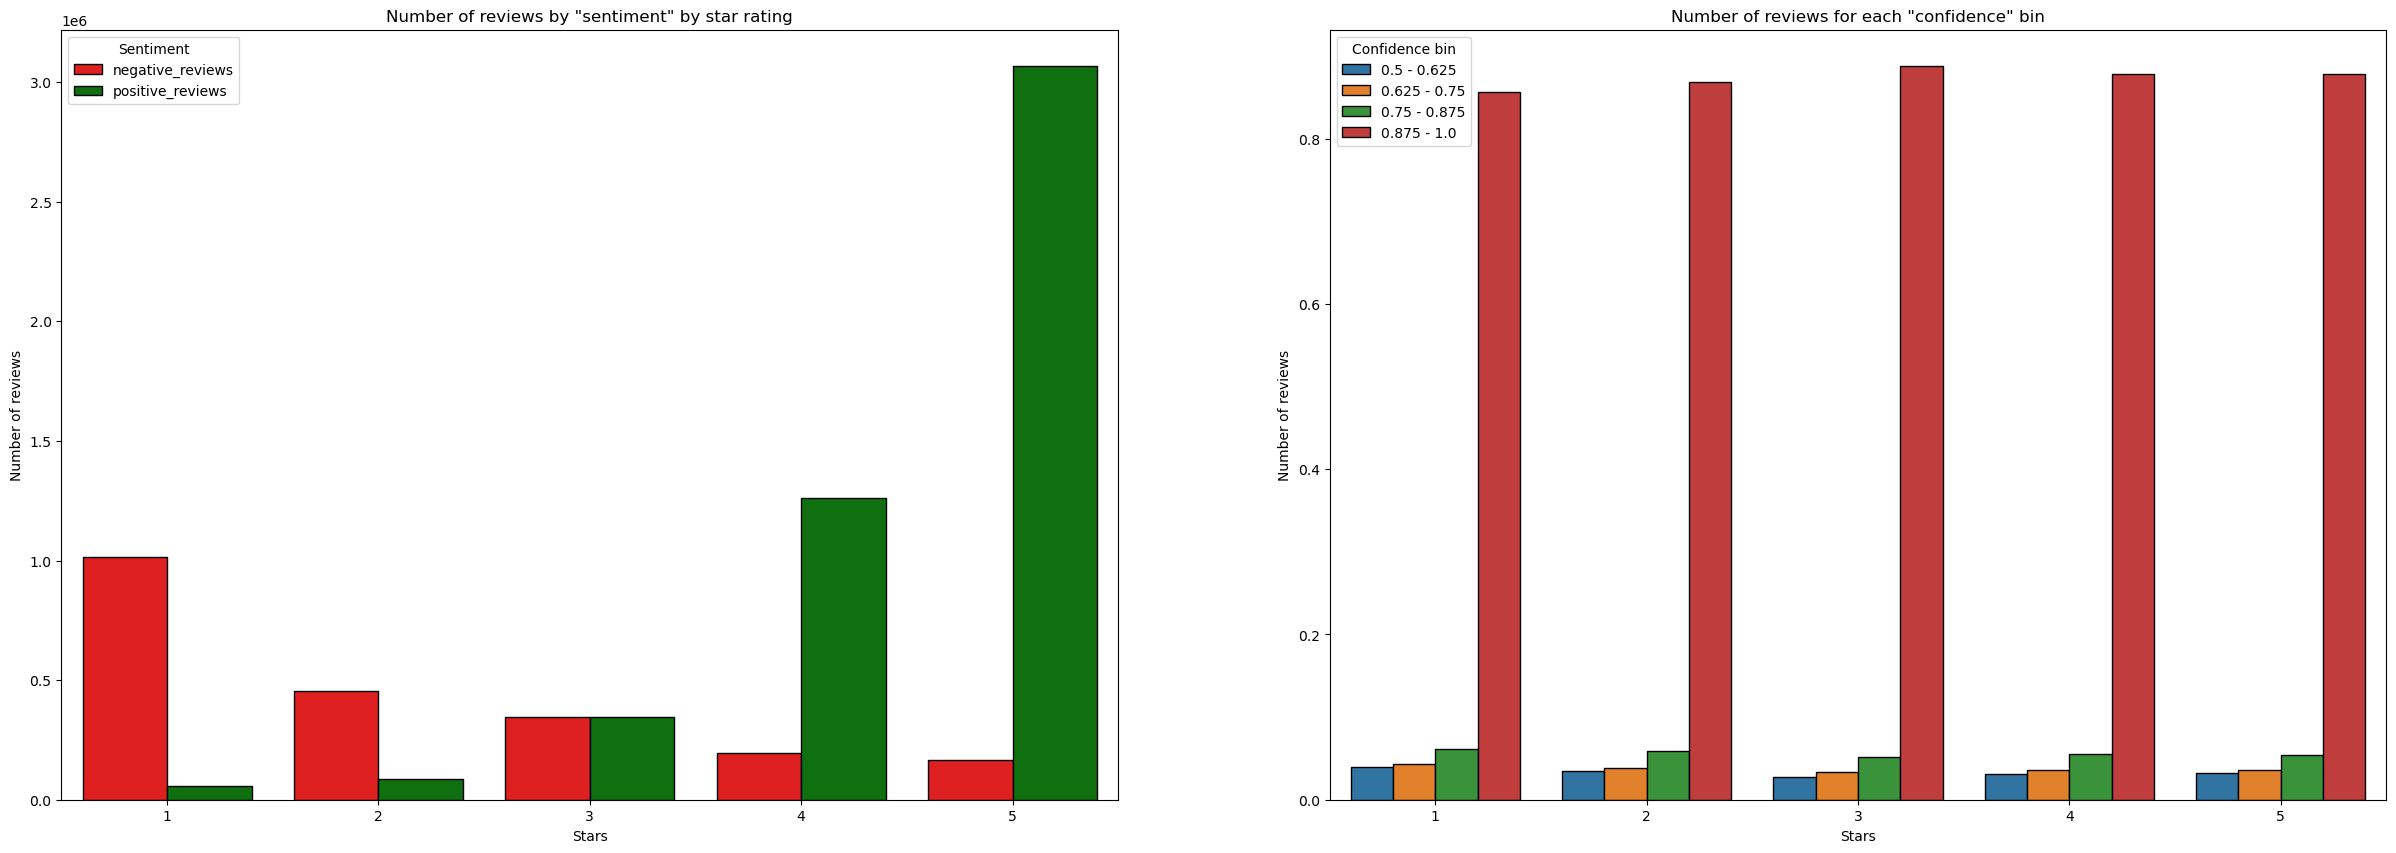

In [39]:
#This labels will appear on the x-axis of the second histogram
bins_labels = [f"{bins[i]} - {bins[i + 1]}" for i in range(len(bins) - 1)]

sentiment_data = sentiment_vs_stars.groupby(["stars", "sentiment"])["num_reviews"]\
                                   .sum()\
                                   .unstack()\
                                   .reset_index()
sentiment_data.columns = ["stars", "negative_reviews", "positive_reviews"]

#Melt "sentiment_data" to prepare it for histogram
sentiment_data_melted = sentiment_data.melt(id_vars = "stars", value_vars = ["negative_reviews", "positive_reviews"], var_name = "sentiment", value_name = "num_reviews")

fig, axes = plt.subplots(1, 2, figsize = (30, 10))
sns.barplot(sentiment_data_melted, x = "stars", y = "num_reviews", hue = "sentiment", palette = {"negative_reviews": "red", "positive_reviews": "green"}, ax = axes[0], edgecolor = "black")

axes[0].set_xlabel("Stars")
axes[0].set_ylabel("Number of reviews")
axes[0].set_title("""Number of reviews by "sentiment" by star rating""")
axes[0].legend(title = "Sentiment")

#Melt "sentiment_vs_star" to prepare it for histogram
sentiment_vs_stars_normalized = sentiment_vs_stars.copy()
sentiment_vs_stars_normalized[["bin_1", "bin_2", "bin_3", "bin_4"]] = sentiment_vs_stars[["bin_1", "bin_2", "bin_3", "bin_4"]].div(sentiment_vs_stars["num_reviews"], axis = 0)
bins_data = sentiment_vs_stars_normalized[["stars", "bin_1", "bin_2", "bin_3", "bin_4"]].melt(id_vars = "stars", var_name = "bin", value_name = "num_reviews")
bins_data["bin"] = bins_data["bin"].replace({f"bin_{i + 1}" : bins_labels[i] for i in range(4)})

# Plotting the second histogram with seaborn
sns.barplot(bins_data, x = "stars", y = "num_reviews", hue = "bin", palette = "tab10", ax = axes[1], edgecolor = "black", errorbar = None)

axes[1].set_xlabel("Stars")
axes[1].set_ylabel("Number of reviews")
axes[1].set_title("""Number of reviews for each "confidence" bin""")
axes[1].legend(title = "Confidence bin")
plt.show()


##### ***Query 11***
We'll search for outlayers in the reviews, i.e. reviews that have positive (negative) sentiment, but low (high) number of stars under the convention that positive (negative) sentiments are typically associated with $\text{stars} \geq 3.0$ ($\text{stars} \leq 2.0$). We'll try to quantify the impact of those outlayers on the average reviews score. Consider, only, businesses with at least 50 reviews to guarantee a low bias in the analysis.

In [ ]:
query_results = db["businesses_merged"].aggregate([{
                                                       "$match" : {
                                                           "$expr" : {
                                                               "$gte" : [{"$size" : "$reviews"}, 50]
                                                           }
                                                       }
                                                   },
                                                   {
                                                       "$unwind" : "$reviews"
                                                   },
                                                   {
                                                       "$group" : {
                                                           "_id" : "$business_id",
                                                           "name" : {
                                                               "$first" : "$name"
                                                           },
                                                           "city" : {
                                                               "$first" : "$city"
                                                           },
                                                           "measured_avg_rating" : {
                                                               "$avg" : "$reviews.stars"
                                                           },
                                                           "measured_var_rating" : {
                                                               "$stdDevPop" : "$reviews.stars"
                                                           },
                                                           "reviews" : {
                                                               "$addToSet" : "$reviews"
                                                           },
                                                           "num_reviews" : {
                                                               "$sum" : 1
                                                           }
                                                       }
                                                   },
                                                   {
                                                       "$unwind" : "$reviews"
                                                   },
                                                   {
                                                       "$match" : {
                                                           "$expr" : {
                                                               "$or" : [
                                                                   {
                                                                       "$and" : [{
                                                                           "$gte" : ["$reviews.stars", 4]
                                                                       }, 
                                                                       {
                                                                           "$eq" : ["$reviews.sentiment", "positive"]
                                                                       }]
                                                                   },
                                                                   {
                                                                       "$and" : [{
                                                                           "$lte" : ["$reviews.stars", 2]
                                                                       },
                                                                       {
                                                                           "$eq" : ["$reviews.sentiment", "negative"]
                                                                       }]
                                                                   }
                                                               ]
                                                           }
                                                       }
                                                   },
                                                   {
                                                       "$group" : {
                                                           "_id" : "$_id",
                                                           #**{field: {"$first" : f"${field}"} for field in ["name", "city", "measured_avg_rating", "measured_var_rating"]}, #Writing "field" : {"$first" : "$field"} is verbose and repetitive, in this way we can avoid it!
                                                           "name" : {
                                                               "$first" : "$name"
                                                           },
                                                           "city" : {
                                                               "$first" : "$city"
                                                           },
                                                           "measured_avg_rating" : {
                                                               "$first" : "$measured_avg_rating"
                                                           },
                                                           "measured_var_rating" : {
                                                               "$first" : "$measured_var_rating"
                                                           },
                                                           "num_reviews" : {
                                                               "$first" : "$num_reviews"
                                                           },
                                                           "filtered_avg_rating" : {
                                                               "$avg" : "$reviews.stars"
                                                           },
                                                           "filtered_var_rating" : {
                                                               "$stdDevPop" : "$reviews.stars"
                                                           },
                                                           "num_filtered_reviews" : {
                                                               "$sum" : 1
                                                           }
                                                       }
                                                   },
                                                   {
                                                       "$addFields" : {
                                                           "abs_avg_diff" : {
                                                               #"abs" operator is used to compute the absolute value of a number
                                                               "$abs" : {
                                                                   #"subtract" operator is used to compute the difference between two numbers
                                                                   "$subtract" : ["$filtered_avg_rating", "$measured_avg_rating"]
                                                               }
                                                           },
                                                           "abs_var_diff" : {
                                                               "$abs" : {
                                                                   "$subtract" : ["$filtered_var_rating", "$measured_var_rating"]
                                                               }
                                                           },
                                                           "biased_ratio" : {
                                                               "$divide" : [{"$subtract" : ["$num_reviews", "$num_filtered_reviews"]}, "$num_reviews"]
                                                           }
                                                       }
                                                   },
                                                   {
                                                       "$sort" : {
                                                           "biased_ratio" : -1,
                                                           "abs_var_diff" : -1,
                                                           "abs_avg_diff" : -1
                                                       }
                                                   },
                                                   {
                                                       "$project" : {
                                                           "business_id" : "$_id",
                                                           "_id" : 0,
                                                           "name" : 1,
                                                           "city" : 1,
                                                           "measured_avg_rating" : 1,
                                                           "filtered_avg_rating" : 1,
                                                           "measured_var_rating" : 1,
                                                           "filtered_var_rating" : 1,
                                                           "biased_ratio" : 1
                                                       }
                                                   }])

filtered_vs_measured = pd.DataFrame(query_results)
filtered_vs_measured

,name,city,measured_avg_rating,measured_var_rating,filtered_avg_rating,filtered_var_rating,biased_ratio,business_id
0,Asia Supermarket,Philadelphia,3.362069,0.941354,3.521739,1.280950,0.603448,Vj28PSL29SUCUzGfkZpaDg
1,Riverwalk Marketplace,New Orleans,2.753247,0.913902,2.468750,1.249609,0.584416,gaP8UpEO1tC-78P4wUA68A
2,Ajax Auto Glass,Philadelphia,4.622642,0.758012,4.625000,0.856957,0.547170,JiXca3iilV4FewV2zTo0TA
3,Sweet Tomatoes,Creve Coeur,3.400000,0.894427,3.478261,1.137104,0.540000,GlrIiN9NUVCy4sRhbh3ajA
4,Shops At Liberty Place,Philadelphia,3.473684,0.904283,3.931818,1.008999,0.536842,Az1Xl-Wz_VXgswIW4OyAGQ
...,...,...,...,...,...,...,...,...
30176,First Advantage Corporation,Saint Petersburg,1.000000,0.000000,1.000000,0.000000,0.000000,Snjy6RdQIkwVMLyaq5Lq1A
30177,Stephen The Spectacular,Tucson,5.000000,0.000000,5.000000,0.000000,0.000000,OnMbuZtEOeTfDOeQprUUkQ
30178,Progressive Business Publications,Malvern,1.202703,0.853921,1.202703,0.853921,0.000000,algUPN4a2nzq9DK0k2gYzA
30179,Truong & Company Jeweler,Santa Barbara,5.000000,0.000000,5.000000,0.000000,0.000000,oDnnlCOYpkMZwOv0oFSp4A


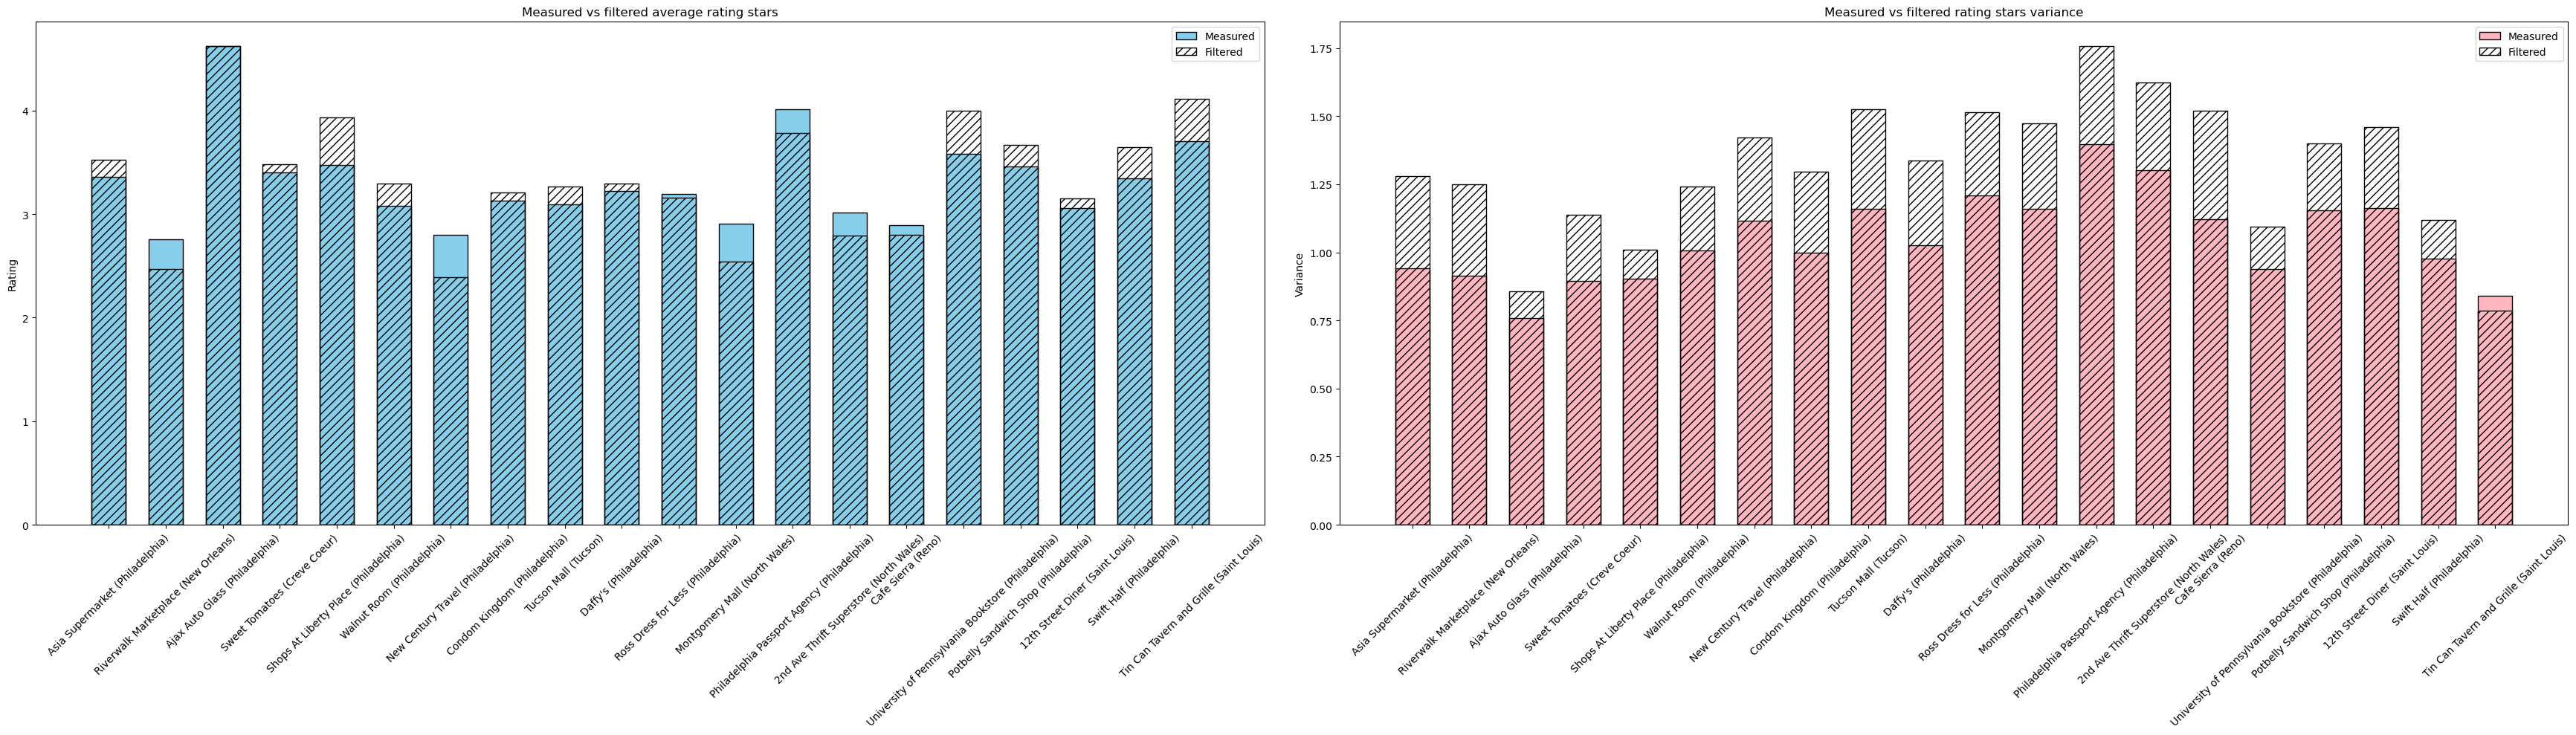

In [83]:
#Display only some of the businesses with the largest abs difference between measured and filtered average or variance
to_display = filtered_vs_measured[:20]

avg_data = pd.DataFrame({
    "Business" : [f"{name} ({city})" for name, city in zip(to_display["name"], to_display["city"])],
    "Measured" : to_display["measured_avg_rating"],
    "Filtered" : to_display["filtered_avg_rating"]
})

var_data = pd.DataFrame({
    "Business": [f"{name} ({city})" for name, city in zip(to_display["name"], to_display["city"])],
    "Measured": to_display["measured_var_rating"],
    "Filtered": to_display["filtered_var_rating"]
})

#Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (35, 10))

#Average
x = range(len(avg_data))
ax1.bar(x, avg_data["Measured"], label = "Measured", color = "skyblue", edgecolor = "black", width = 0.6)
ax1.bar(x, avg_data["Filtered"], label = "Filtered", color = "none", edgecolor = "black", hatch = "///", width = 0.6)
ax1.set_xticks(x)
ax1.set_xticklabels(avg_data["Business"], rotation = 45)
ax1.set_title("Measured vs filtered average rating stars")
ax1.set_ylabel("Rating")
ax1.legend()

#Variance
x = range(len(var_data))
ax2.bar(x, var_data["Measured"], label = "Measured", color = "#FFB6C1", edgecolor = "black", width = 0.6)
ax2.bar(x, var_data["Filtered"], label = "Filtered", color = "none", edgecolor = "black", hatch = "///", width = 0.6)
ax2.set_xticks(x)
ax2.set_xticklabels(var_data["Business"], rotation = 45)
ax2.set_title("Measured vs filtered rating stars variance")
ax2.set_ylabel("Variance")
ax2.legend()

#Bias ratio
#x = range(len(var_data))
#ax3.bar(x, filtered_vs_measured["biased_ratio"][:20], color = "lightGreen", edgecolor = "black", width = 0.6)
#ax3.set_xticks(x)
#ax3.set_xticklabels(var_data["Business"], rotation = 45)
#ax3.set_title("Biased reviews percentage")
#ax3.set_ylabel("Percentage")

plt.tight_layout()
plt.show()